In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
import random
import os
import json
import numpy as np

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
from gaussian_process_example import *

df = pd.read_csv('gp_objects.csv')
display(df)
obj = sorted(df.obj_id.unique())

mjd   flux_ztfg   flux_ztfi   flux_ztfr  flux_error_ztfg  \
0      57983.231000  385.374906  440.341788  404.940209        29.250027   
1      57983.239778  382.559484  438.232033  402.502588        28.789575   
2      57983.248556  379.738177  436.119876  400.065220        28.332873   
3      57983.257333  376.910979  434.005567  397.628148        27.879986   
4      57983.266111  374.077886  431.889351  395.191413        27.430981   
...             ...         ...         ...         ...              ...   
73996  60913.250852    3.143694    9.806161    7.127932         0.115217   
73997  60913.258955    3.161257    9.826886    7.146532         0.115187   
73998  60913.267058    3.178820    9.847333    7.164981         0.116439   
73999  60913.275161    3.196376    9.867496    7.183280         0.119048   
74000  60913.283264    3.213920    9.887368    7.201429         0.122988   

       flux_error_ztfi  flux_error_ztfr       type        obj_id  \
0            17.182907        24.797305   Kilonova     AT2017gfo   
1            16.890215        24.361032   Kilonova     AT2017gfo   
2            16.606597        23.927709   Kilonova     AT2017gfo   
3            16.332054        23.497397   Kilonova     AT2017gfo   
4            16.066587        23.070161   Kilonova     AT2017gfo   
...                ...              ...        ...           ...   
73996         0.340238         0.728066  AT2025ulz  ZTF25abjmnps   
73997         0.342336         0.736882  AT2025ulz  ZTF25abjmnps   
73998         0.344971         0.745716  AT2025ulz  ZTF25abjmnps   
73999         0.348165         0.754567  AT2025ulz  ZTF25abjmnps   
74000         0.351939         0.763435  AT2025ulz  ZTF25abjmnps   

              mjd_0  ...   mag_ztfg  abs_mag_ztfg  mag_error_ztfg   mag_ztfr  \
0      57983.231000  ...  17.435291    -15.778388        0.082408  17.381523   
1      57983.231000  ...  17.443253    -15.770427        0.081707  17.388078   
2      57983.231000  ...  17.451289    -15.762390        0.081009  17.394673   
3      57983.231000  ...  17.459403    -15.754277        0.080312  17.401307   
4      57983.231000  ...  17.467595    -15.746085        0.079617  17.407981   
...             ...  ...        ...           ...             ...        ...   
73996  60905.188368  ...  22.656399    -15.350703        0.039792  21.767591   
73997  60905.188368  ...  22.650351    -15.356752        0.039561  21.764762   
73998  60905.188368  ...  22.644335    -15.362768        0.039770  21.761962   
73999  60905.188368  ...  22.638355    -15.368747        0.040438  21.759193   
74000  60905.188368  ...  22.632412    -15.374690        0.041548  21.756453   

       abs_mag_ztfr  mag_error_ztfr   mag_ztfi  abs_mag_ztfi  mag_error_ztfi  \
0        -15.832157        0.066487  17.290525    -15.923154        0.042367   
1        -15.825601        0.065713  17.295740    -15.917940        0.041846   
2        -15.819007        0.064937  17.300985    -15.912694        0.041343   
3        -15.812372        0.064160  17.306262    -15.907418        0.040857   
4        -15.805698        0.063382  17.311569    -15.902111        0.040390   
...             ...             ...        ...           ...             ...   
73996    -16.239511        0.110900  21.421252    -16.585850        0.037671   
73997    -16.242341        0.111951  21.418960    -16.588142        0.037823   
73998    -16.245140        0.113001  21.416703    -16.590399        0.038035   
73999    -16.247910        0.114051  21.414483    -16.592620        0.038309   
74000    -16.250649        0.115101  21.412298    -16.594804        0.038647   

              t  
0      0.000000  
1      0.008778  
2      0.017556  
3      0.026333  
4      0.035111  
...         ...  
73996  8.062484  
73997  8.070587  
73998  8.078690  
73999  8.086793  
74000  8.094896  

[74001 rows x 21 columns]

In [2]:
color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
def plot_gp(obj_model, number_col=4, show_title=True, show_legend=True):
    color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
    f, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Time (mjd)')
    ax.set_ylabel('Flux') 
    if show_title:
        obj_id = obj_model['obj_id'].iloc[0]
        ax.set_title(f'Light Curve for Object ID: {obj_id} | Type: {obj_model["type"].iloc[0]}')
    if show_legend:
        ax.legend(ncol=number_col)

    # Plotting model data if available
    if obj_model is not None:
        # Iterate over the filters present in the obj_model DataFrame
        for column in obj_model.columns:
            if 'flux' in column and column != 'mjd' and 'abs' not in column:
                filter_name = column.split('_')[1]
                if filter_name in color_dict:
                    if not all(obj_model[column] == -1):
                        ax.plot(obj_model['t'], obj_model[column], label=f'Model {filter_name}', color=color_dict[filter_name])
    
                        # Plot error band if error data is available
                        error_column = f'flux_error_{filter_name}'
                        if error_column in obj_model.columns:
                            model_flux_error = obj_model[error_column]
                            ax.fill_between(obj_model['t'], obj_model[column]-model_flux_error, obj_model[column]+model_flux_error, color=color_dict[filter_name], alpha=0.20)

    return f,ax

In [3]:
def cut_data(df, obj_id, cutoff, plot=True):
    obj_model = df[df['obj_id'] == obj_id]
    if plot:
        f, ax = plot_gp(obj_model)
        ax.axvline(cutoff, color='black', linestyle='--', label='Cutoff')
        plt.show()

    obj_model = obj_model[obj_model['t'] < cutoff]
    combined_df = pd.concat([df[df['obj_id'] != obj_id], obj_model])
    return combined_df

In [4]:
obj[74]

'ZTF25abjmnps'

In [5]:
df[df['obj_id'] == obj[40]]

mjd  flux_ztfg  flux_ztfi  flux_ztfr  flux_error_ztfg  \
40000  59390.264849  53.224508        NaN  42.856080         6.532327   
40001  59390.280858  53.187907        NaN  42.830382         6.596347   
40002  59390.296867  53.105095        NaN  42.791406         6.799717   
40003  59390.312875  52.979612        NaN  42.737942         7.123358   
40004  59390.328884  52.814757        NaN  42.668918         7.545048   
...             ...        ...        ...        ...              ...   
40995  59406.193465  24.024151        NaN  26.041101        15.618604   
40996  59406.209474  24.068046        NaN  26.104938        15.482465   
40997  59406.225483  24.099553        NaN  26.151804        15.383847   
40998  59406.241491  24.118520        NaN  26.180697        15.324113   
40999  59406.257500  24.124852        NaN  26.190567        15.304106   

       flux_error_ztfi  flux_error_ztfr         type        obj_id  \
40000              NaN         5.396206  Ib/c;Ib-pec  ZTF21abhywxv   
40001              NaN         5.381265  Ib/c;Ib-pec  ZTF21abhywxv   
40002              NaN         5.549125  Ib/c;Ib-pec  ZTF21abhywxv   
40003              NaN         5.875878  Ib/c;Ib-pec  ZTF21abhywxv   
40004              NaN         6.328525  Ib/c;Ib-pec  ZTF21abhywxv   
...                ...              ...          ...           ...   
40995              NaN         6.434541  Ib/c;Ib-pec  ZTF21abhywxv   
40996              NaN         5.892925  Ib/c;Ib-pec  ZTF21abhywxv   
40997              NaN         5.460252  Ib/c;Ib-pec  ZTF21abhywxv   
40998              NaN         5.175102  Ib/c;Ib-pec  ZTF21abhywxv   
40999              NaN         5.073936  Ib/c;Ib-pec  ZTF21abhywxv   

              mjd_0  ...   mag_ztfg  abs_mag_ztfg  mag_error_ztfg   mag_ztfr  \
40000  59390.264849  ...  19.584721    -17.177374        0.133254  19.819969   
40001  59390.264849  ...  19.585468    -17.176627        0.134653  19.820620   
40002  59390.264849  ...  19.587160    -17.174936        0.139021  19.821609   
40003  59390.264849  ...  19.589728    -17.172367        0.145982  19.822966   
40004  59390.264849  ...  19.593112    -17.168983        0.155107  19.824721   
...             ...  ...        ...           ...             ...        ...   
40995  59390.264849  ...  20.448380    -16.313715        0.705860  20.360852   
40996  59390.264849  ...  20.446398    -16.315697        0.698431  20.358193   
40997  59390.264849  ...  20.444978    -16.317118        0.693075  20.356246   
40998  59390.264849  ...  20.444123    -16.317972        0.689841  20.355047   
40999  59390.264849  ...  20.443838    -16.318257        0.688760  20.354638   

       abs_mag_ztfr  mag_error_ztfr  mag_ztfi  abs_mag_ztfi  mag_error_ztfi  \
40000    -16.942126        0.136710       NaN           NaN             NaN   
40001    -16.941475        0.136413       NaN           NaN             NaN   
40002    -16.940487        0.140797       NaN           NaN             NaN   
40003    -16.939129        0.149274       NaN           NaN             NaN   
40004    -16.937374        0.161033       NaN           NaN             NaN   
...             ...             ...       ...           ...             ...   
40995    -16.401244        0.268276       NaN           NaN             NaN   
40996    -16.403902        0.245094       NaN           NaN             NaN   
40997    -16.405849        0.226692       NaN           NaN             NaN   
40998    -16.407048        0.214616       NaN           NaN             NaN   
40999    -16.407457        0.210341       NaN           NaN             NaN   

               t  
40000   0.000000  
40001   0.016009  
40002   0.032017  
40003   0.048026  
40004   0.064035  
...          ...  
40995  15.928616  
40996  15.944625  
40997  15.960633  
40998  15.976642  
40999  15.992651  

[1000 rows x 21 columns]

In [6]:
df[df['obj_id'] == obj[7]].describe()

mjd    flux_ztfg  flux_ztfi    flux_ztfr  flux_error_ztfg  \
count   1000.000000  1000.000000        0.0  1000.000000      1000.000000   
mean   58597.816117   183.240171        NaN   159.572482        16.340975   
std        8.359731   118.369048        NaN   109.834246         4.714176   
min    58583.358345    37.237861        NaN    25.213199         4.146844   
25%    58590.587231    69.404153        NaN    51.971791        12.950148   
50%    58597.816117   155.415815        NaN   131.196179        16.746612   
75%    58605.045003   300.261026        NaN   276.223232        20.435642   
max    58612.273889   378.976388        NaN   327.480817        23.302721   

       flux_error_ztfi  flux_error_ztfr         mjd_0      redshift  \
count              0.0      1000.000000  1.000000e+03  1.000000e+03   
mean               NaN        19.957125  5.858336e+04  5.469000e-02   
std                NaN         7.372145  6.915618e-10  6.664671e-16   
min                NaN         4.663951  5.858336e+04  5.469000e-02   
25%                NaN        13.819034  5.858336e+04  5.469000e-02   
50%                NaN        19.954346  5.858336e+04  5.469000e-02   
75%                NaN        23.725766  5.858336e+04  5.469000e-02   
max                NaN        34.083335  5.858336e+04  5.469000e-02   

          mag_ztfg  abs_mag_ztfg  mag_error_ztfg     mag_ztfr  abs_mag_ztfr  \
count  1000.000000   1000.000000     1000.000000  1000.000000   1000.000000   
mean     18.527526    -18.481901        0.164905    18.743734    -18.265694   
std       0.840248      0.840248        0.148486     0.951484      0.951484   
min      17.453470    -19.555958        0.046161    17.612035    -19.397392   
25%      17.706253    -19.303175        0.067068    17.796850    -19.212578   
50%      18.421263    -18.588164        0.089243    18.605198    -18.404229   
75%      19.296538    -17.712889        0.237520    19.610583    -17.398844   
max      19.972538    -17.036889        0.577762    20.395930    -16.613497   

       mag_error_ztfr  mag_ztfi  abs_mag_ztfi  mag_error_ztfi            t  
count     1000.000000       0.0           0.0             0.0  1000.000000  
mean         0.261023       NaN           NaN             NaN    14.457772  
std          0.232465       NaN           NaN             NaN     8.359731  
min          0.043288       NaN           NaN             NaN     0.000000  
25%          0.074516       NaN           NaN             NaN     7.228886  
50%          0.147170       NaN           NaN             NaN    14.457772  
75%          0.417071       NaN           NaN             NaN    21.686658  
max          0.857379       NaN           NaN             NaN    28.915544

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


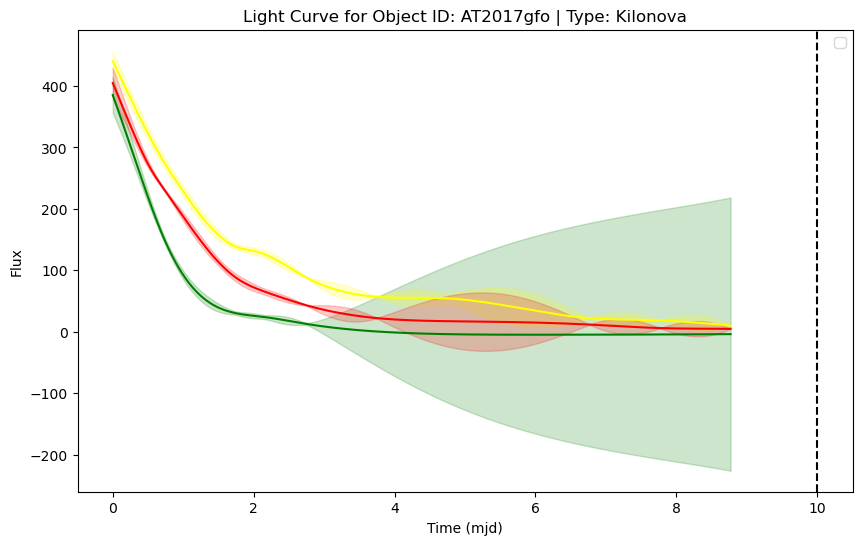

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


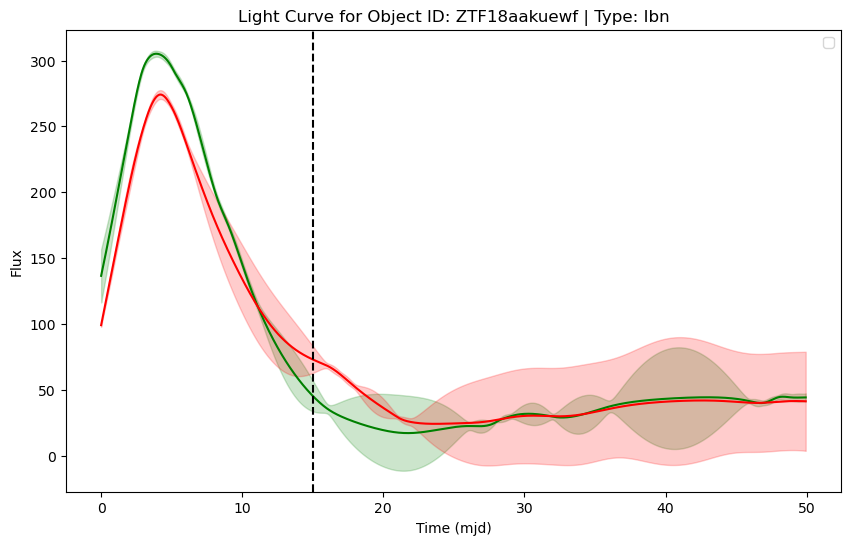

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


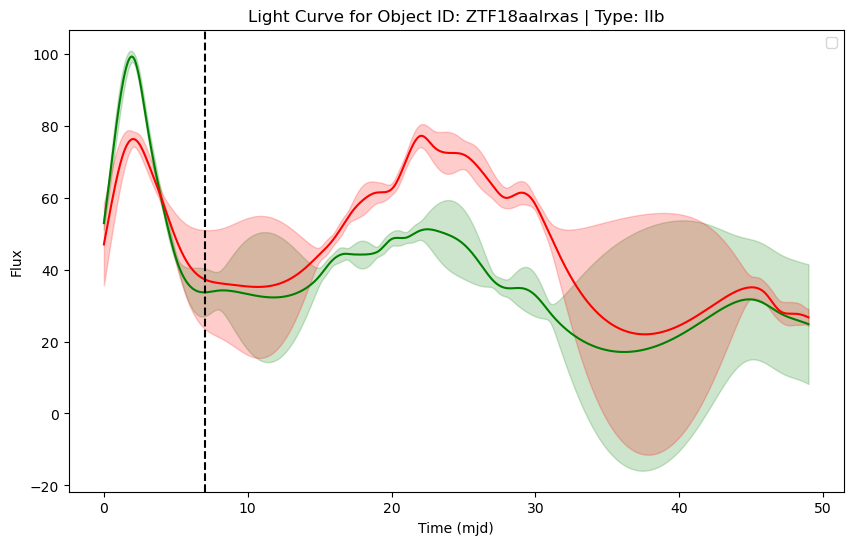

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


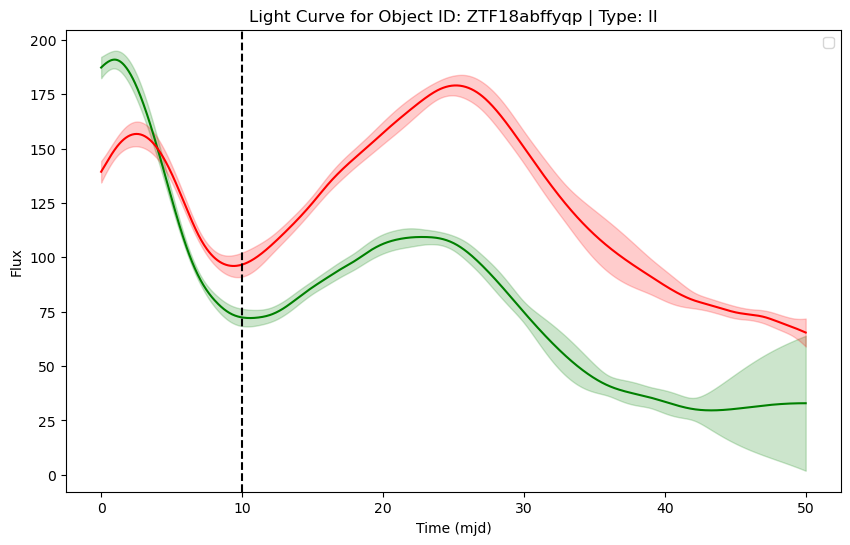

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


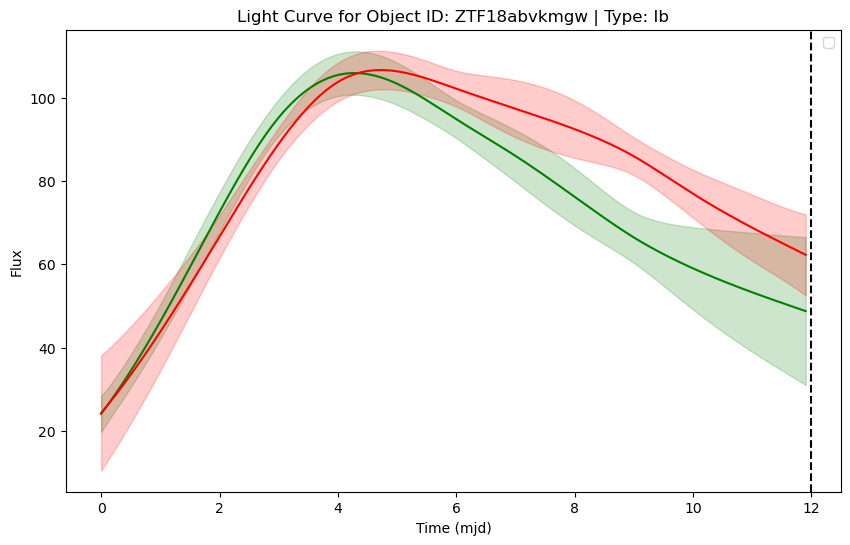

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


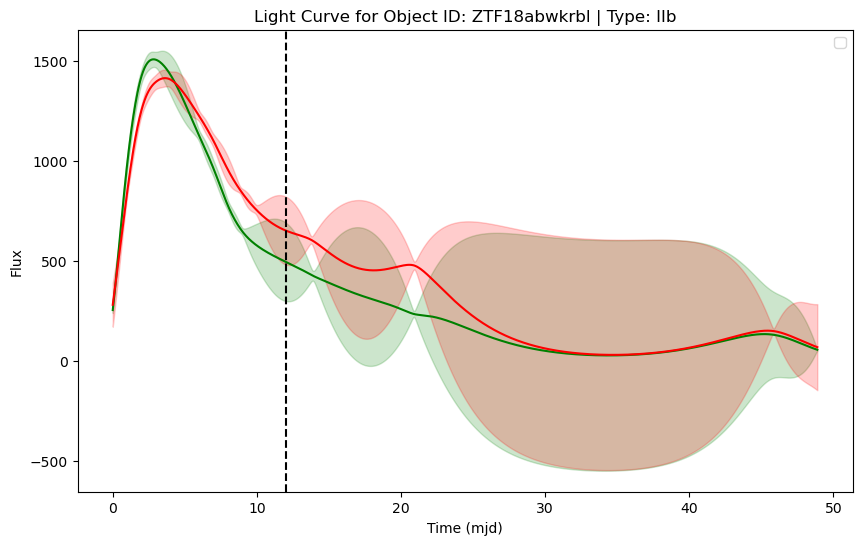

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


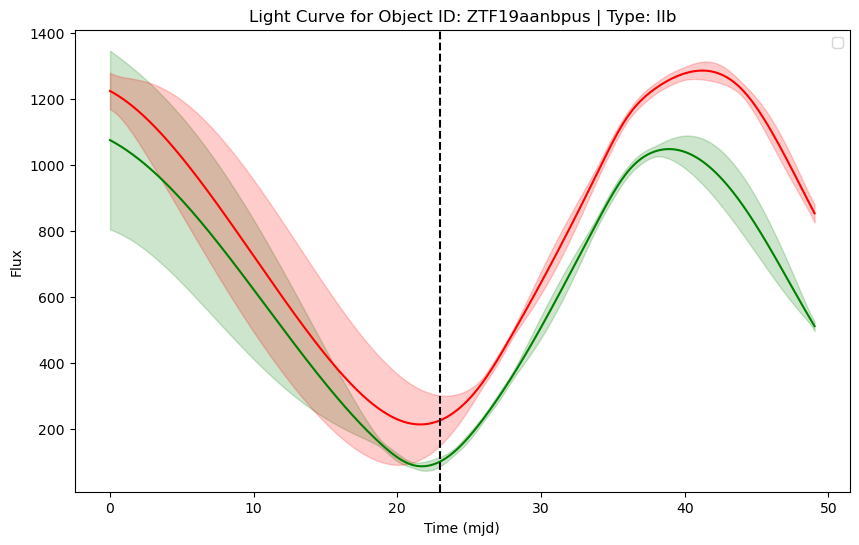

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


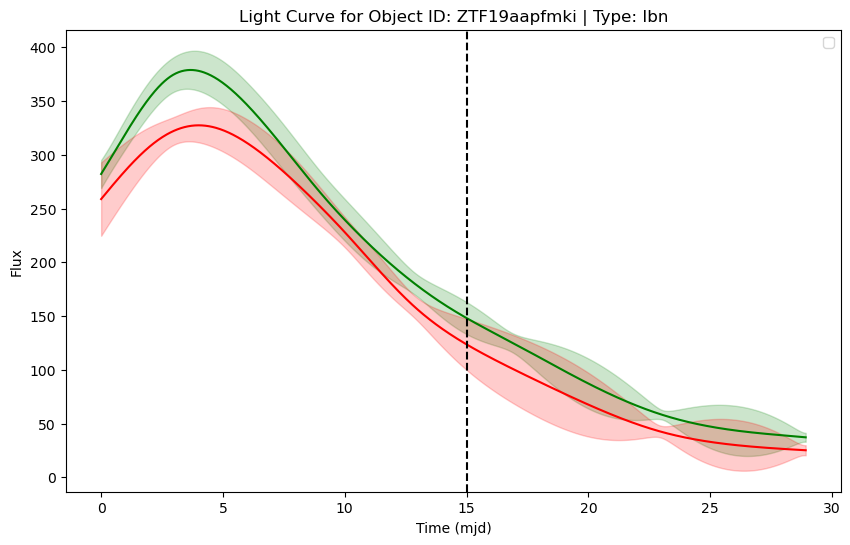

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


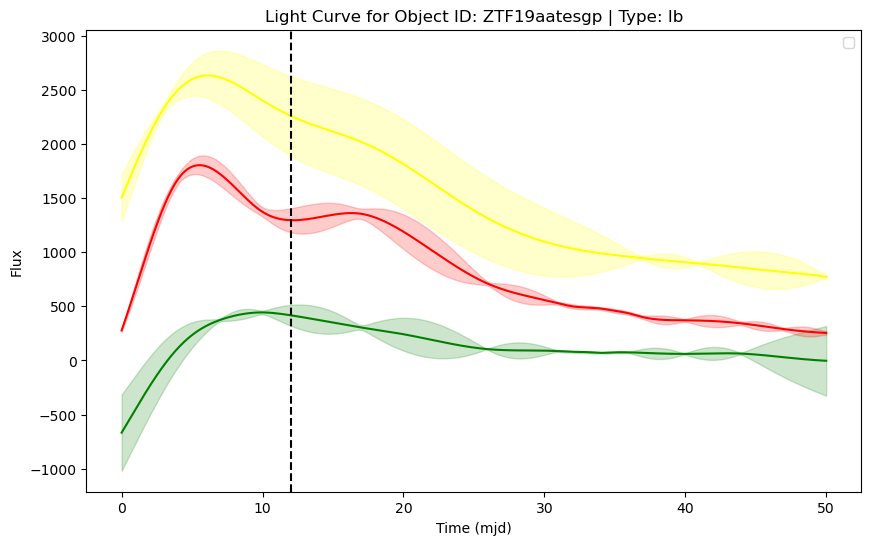

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


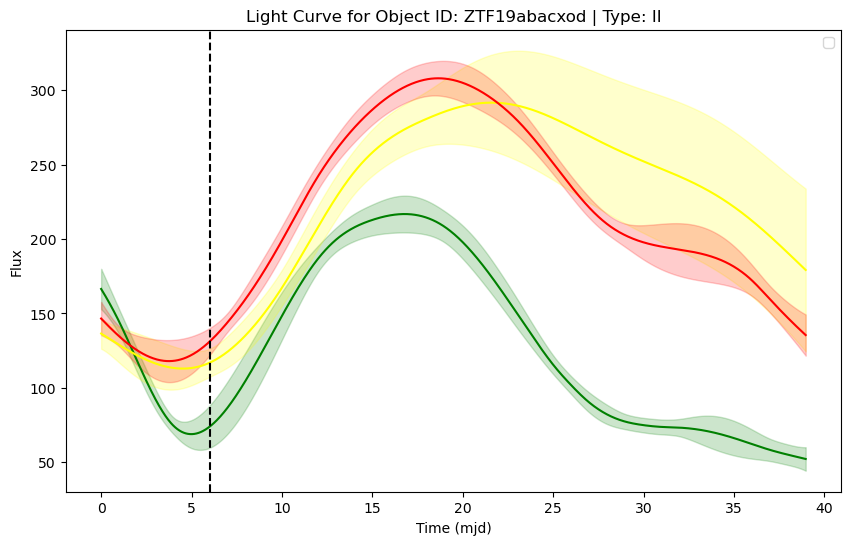

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


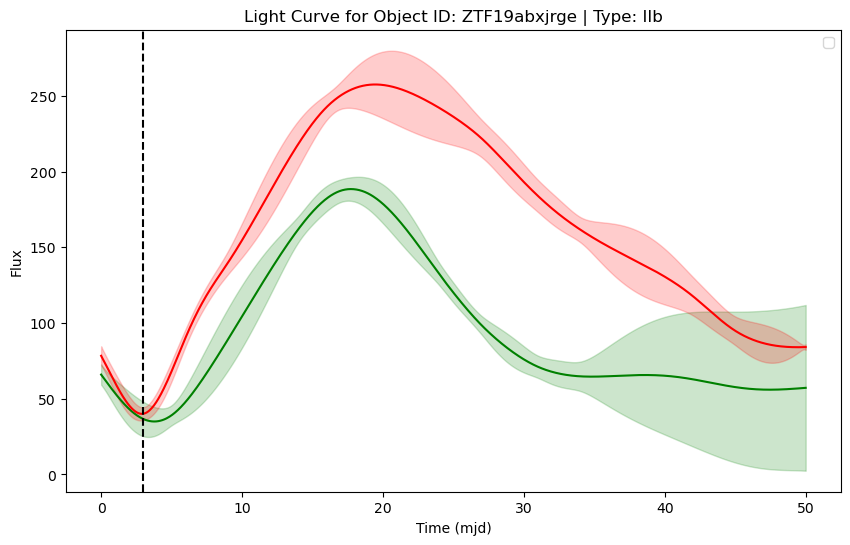

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


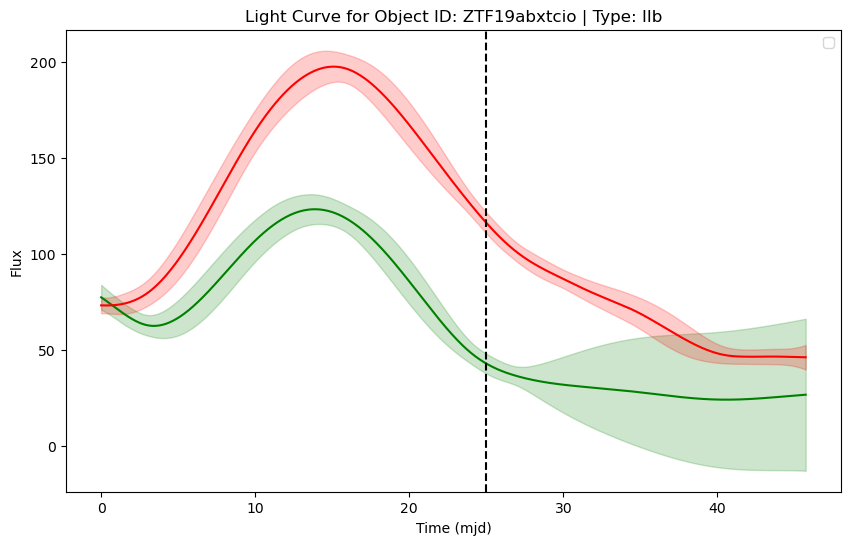

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


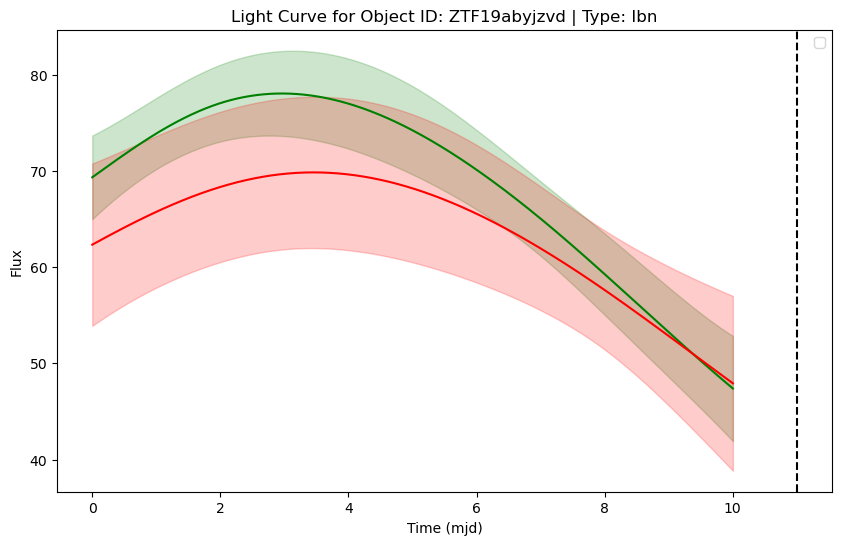

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


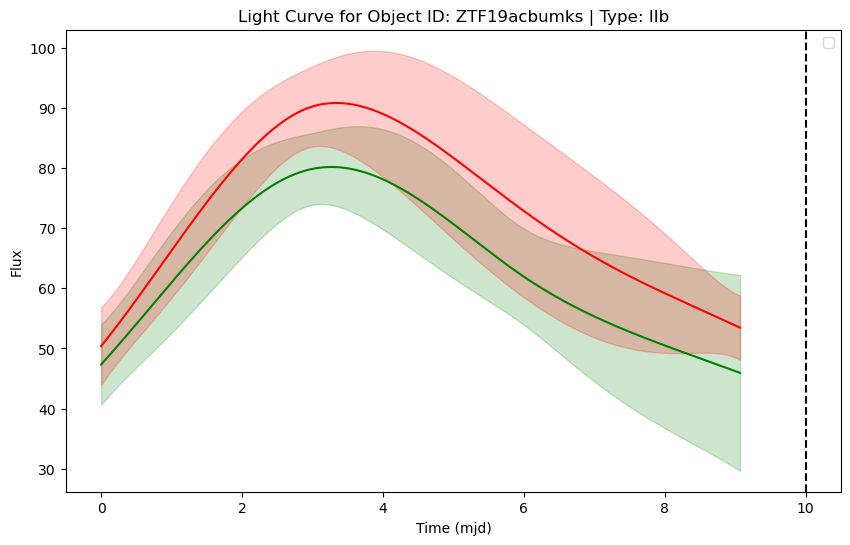

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


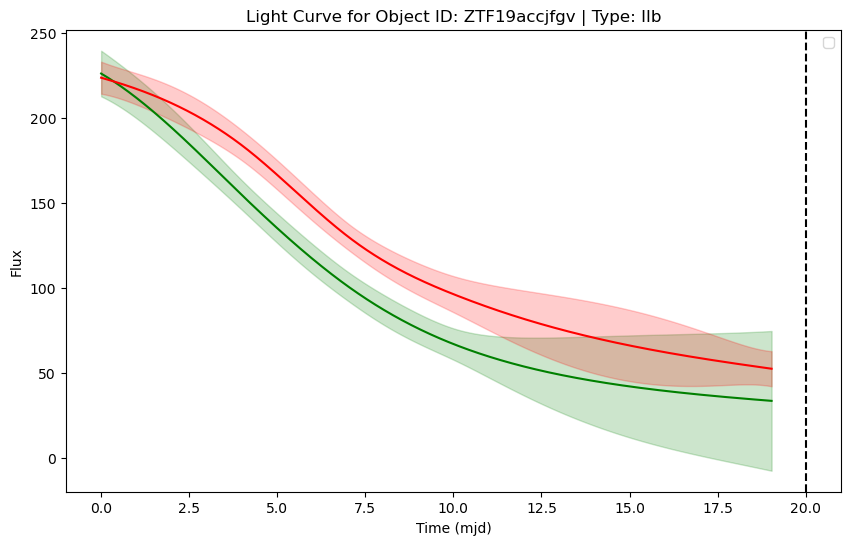

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


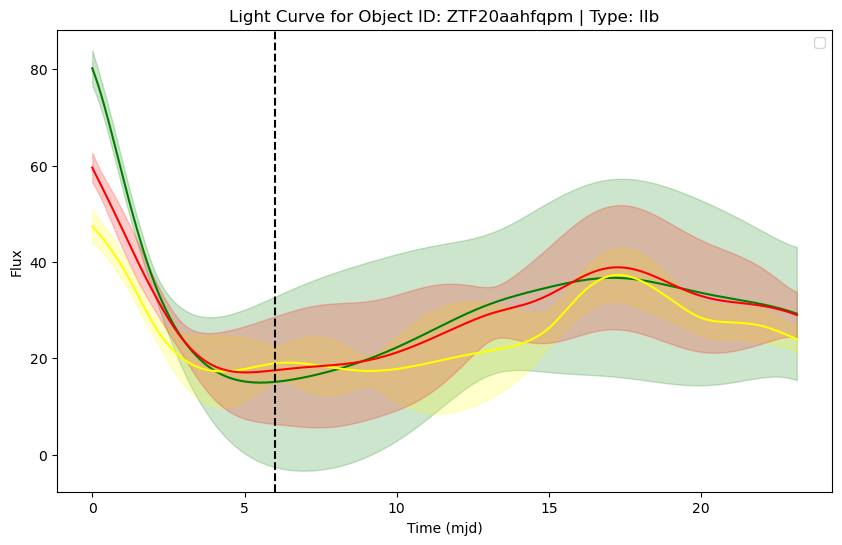

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


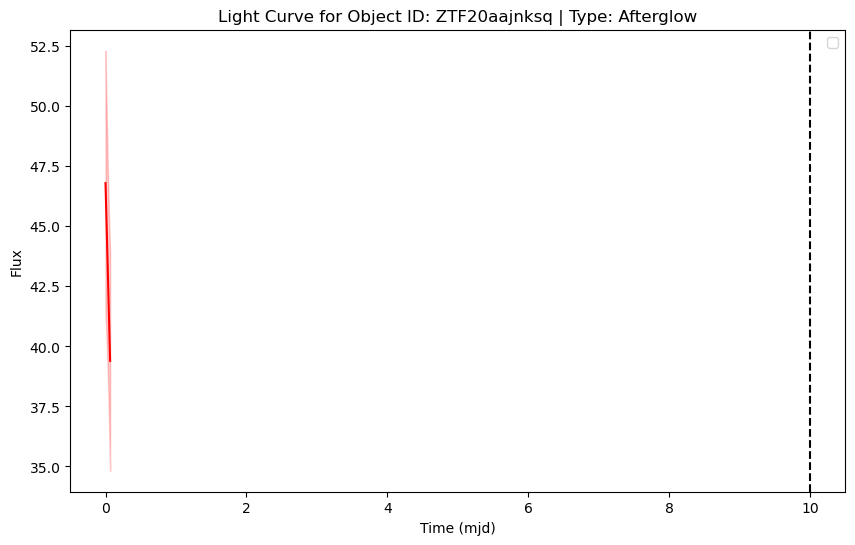

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


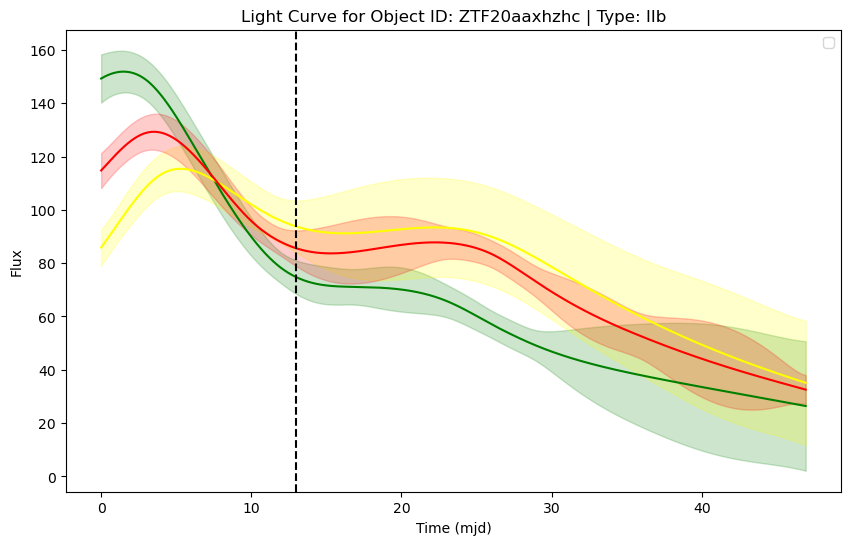

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


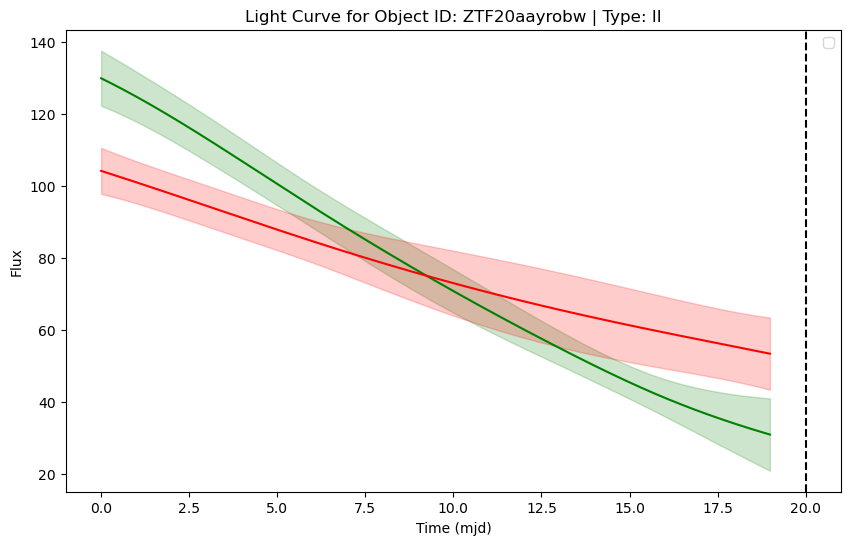

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


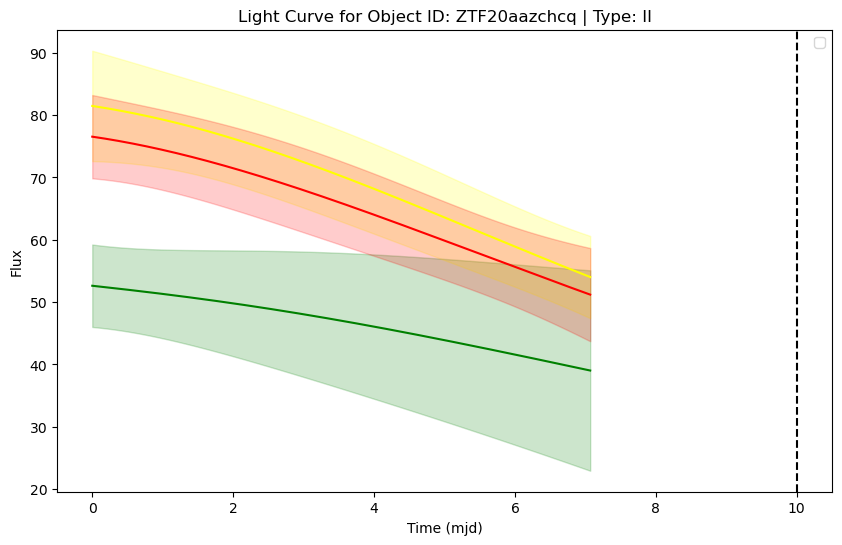

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


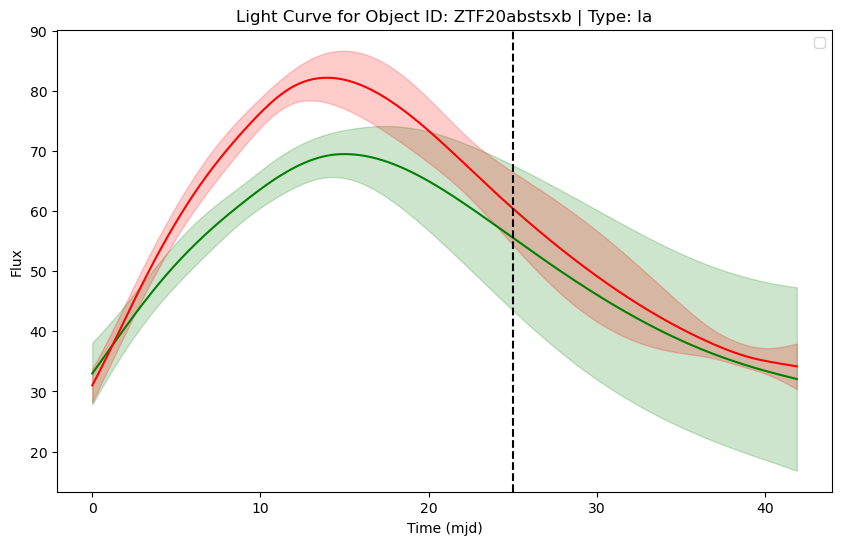

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


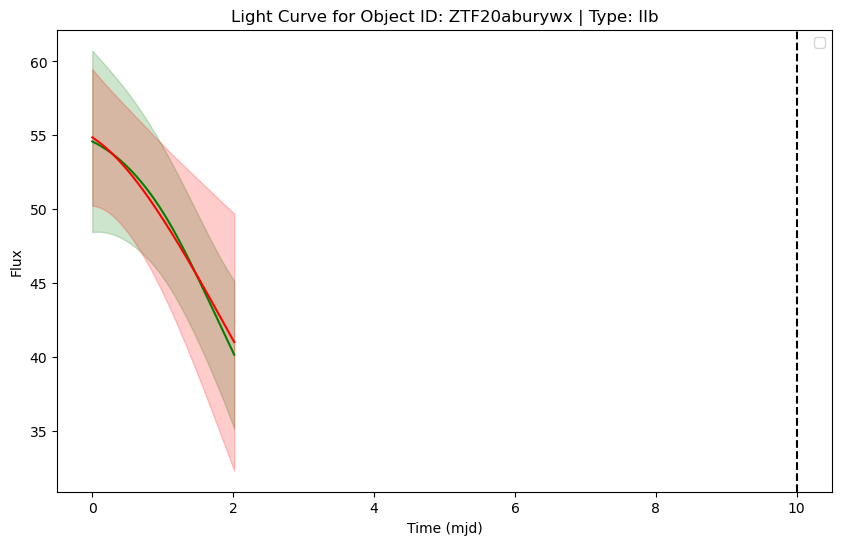

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


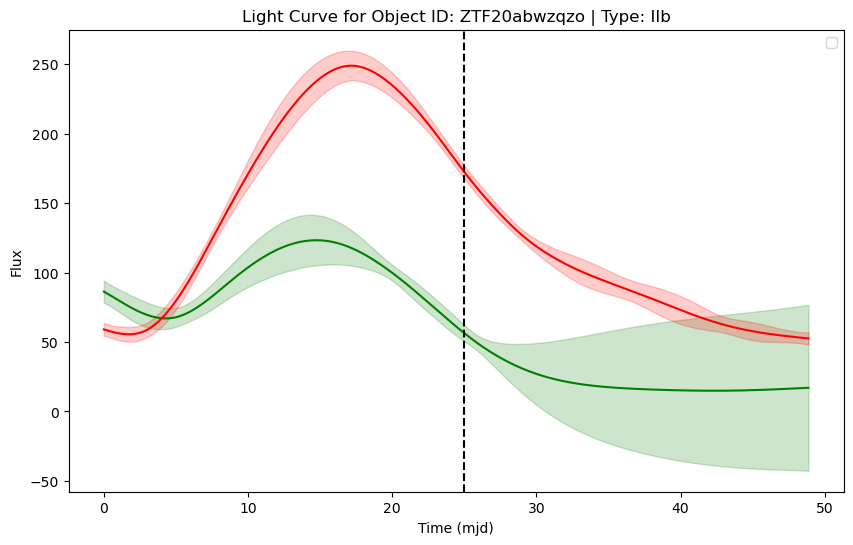

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


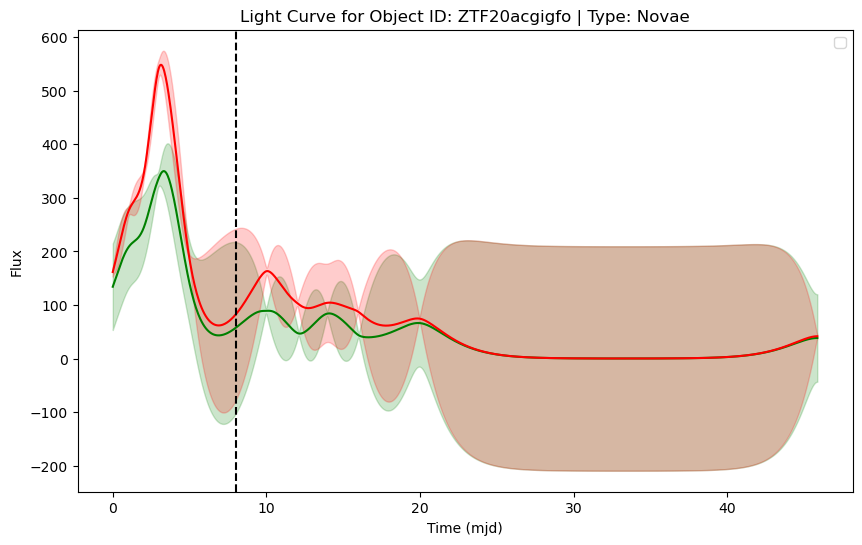

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


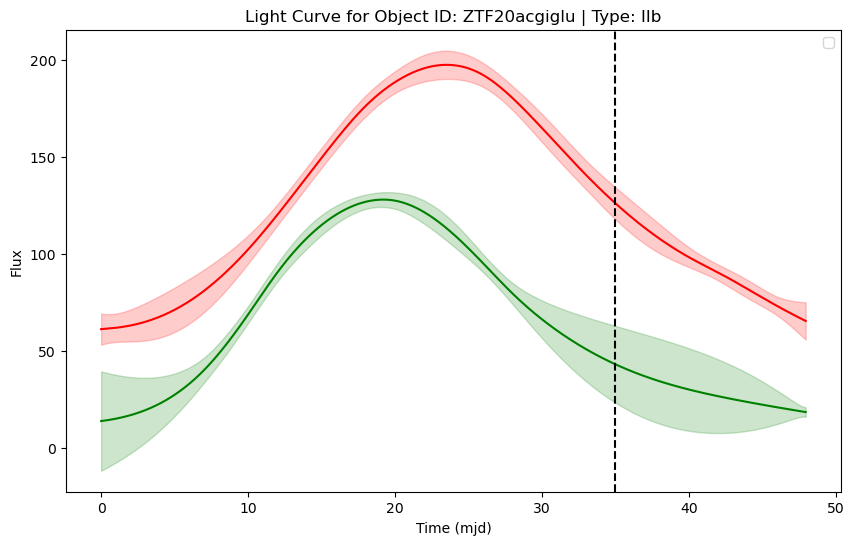

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


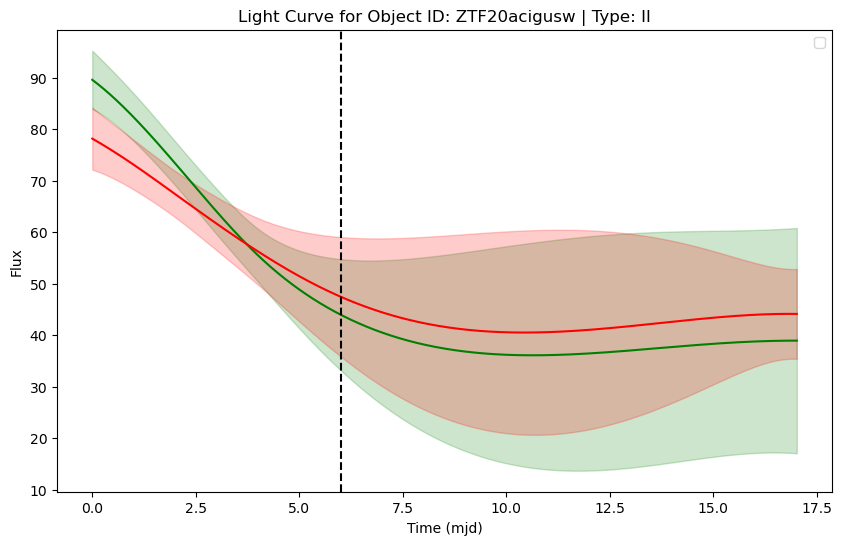

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


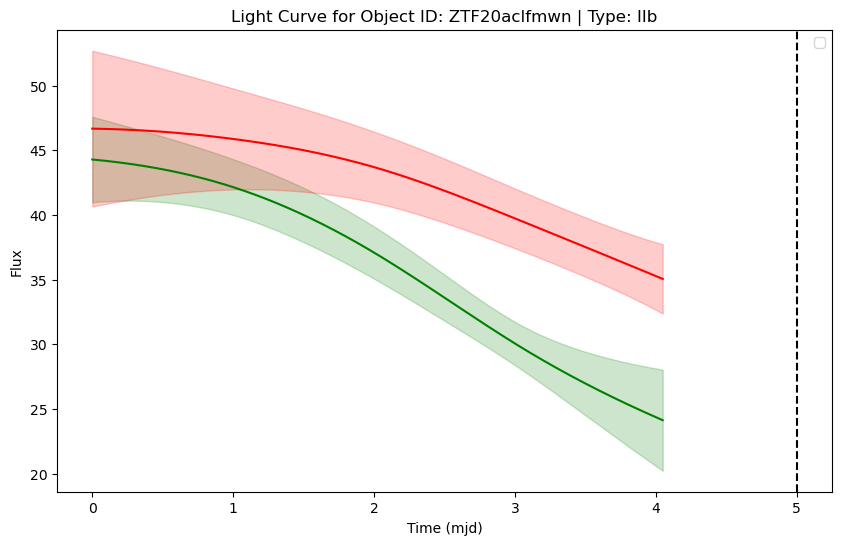

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


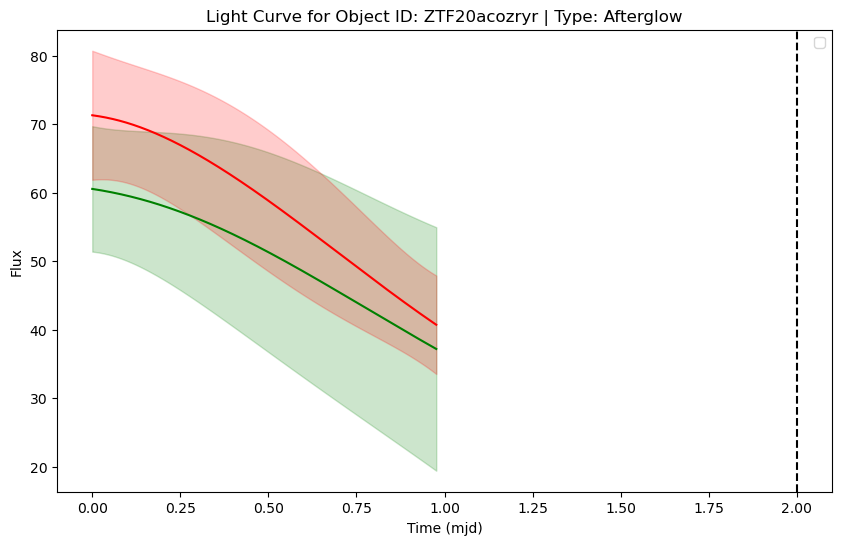

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


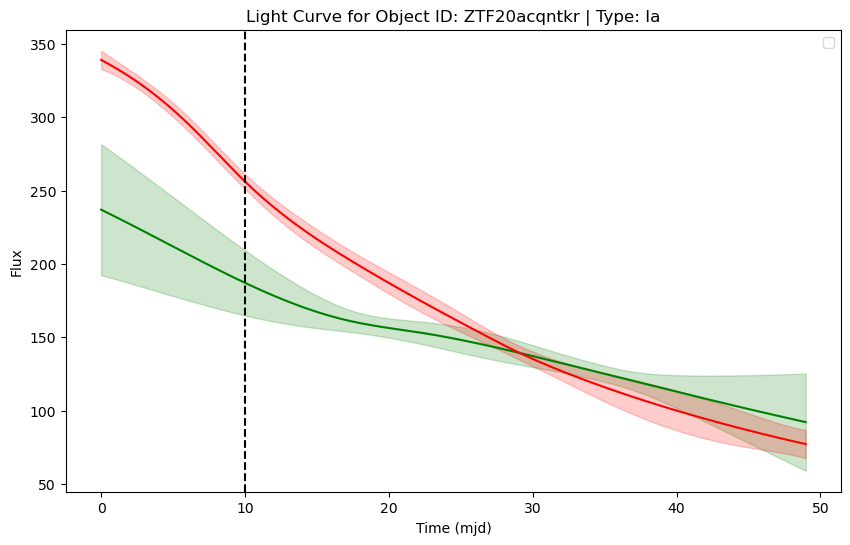

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


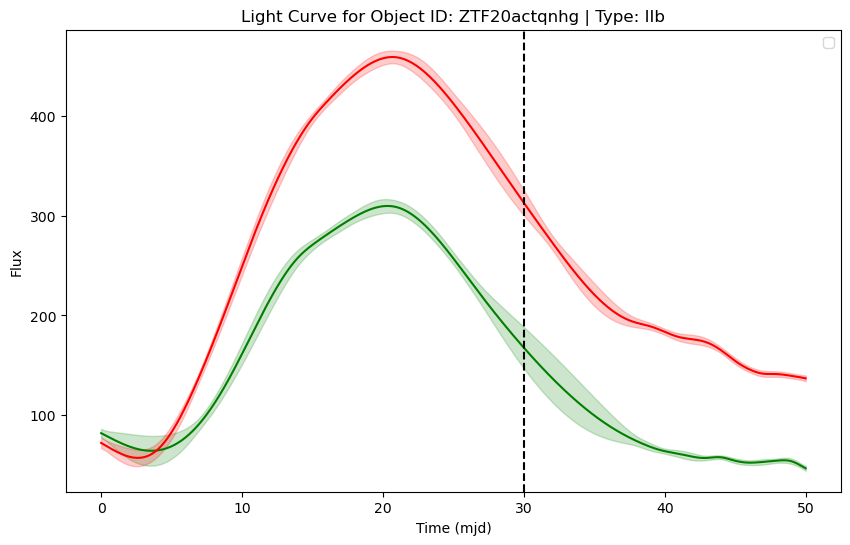

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


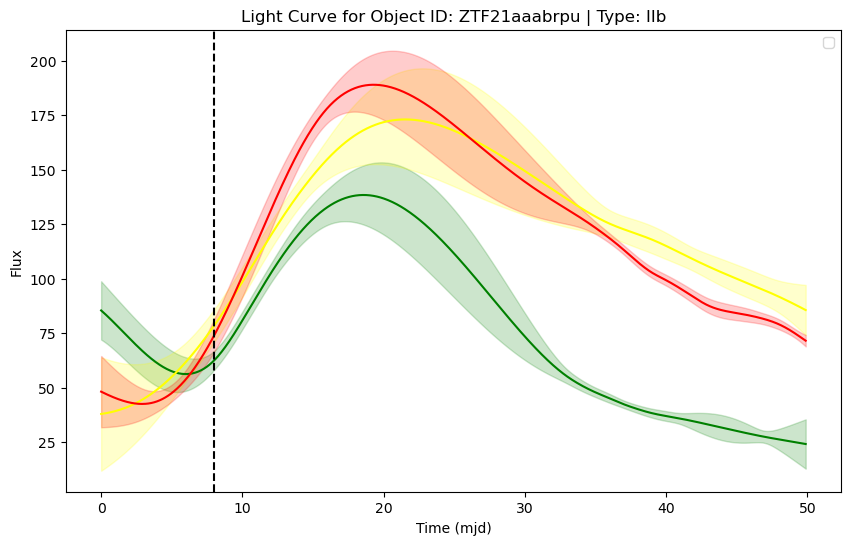

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


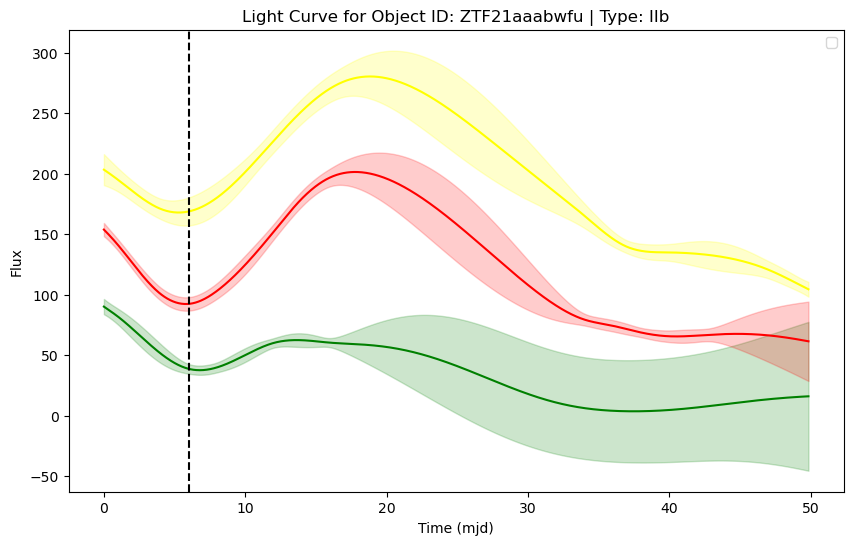

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


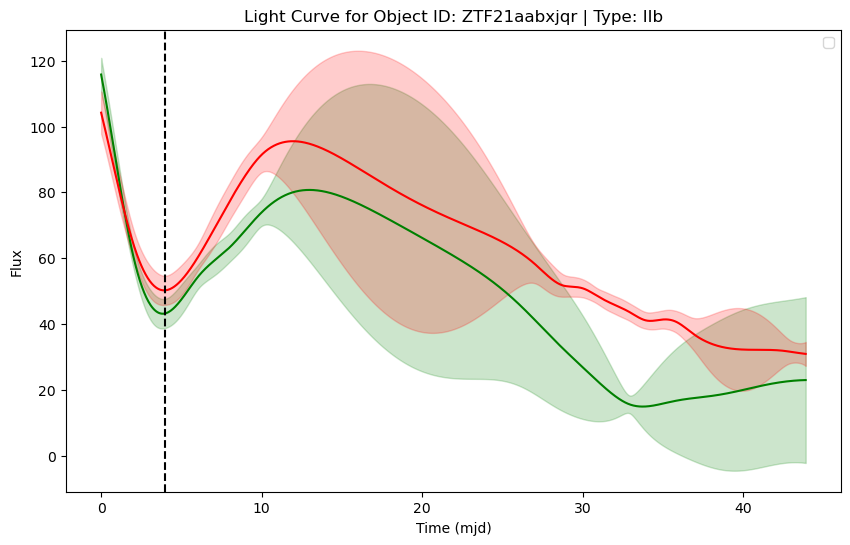

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


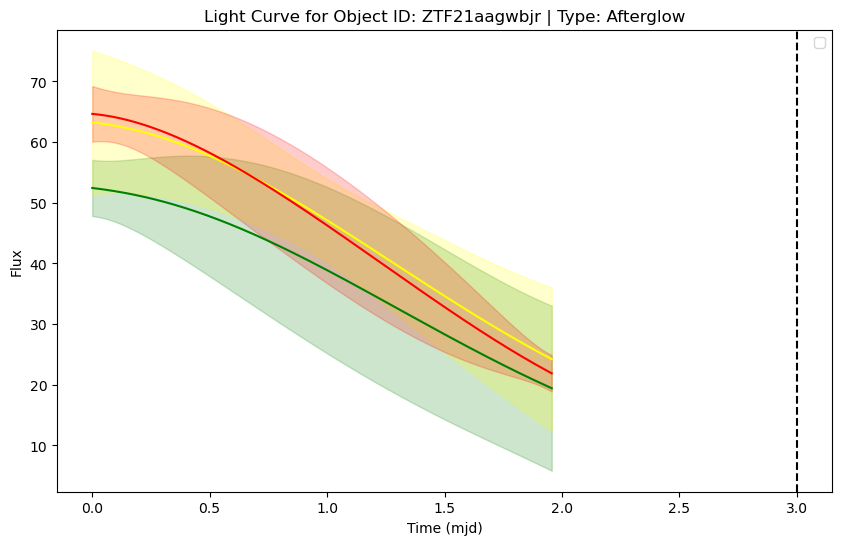

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


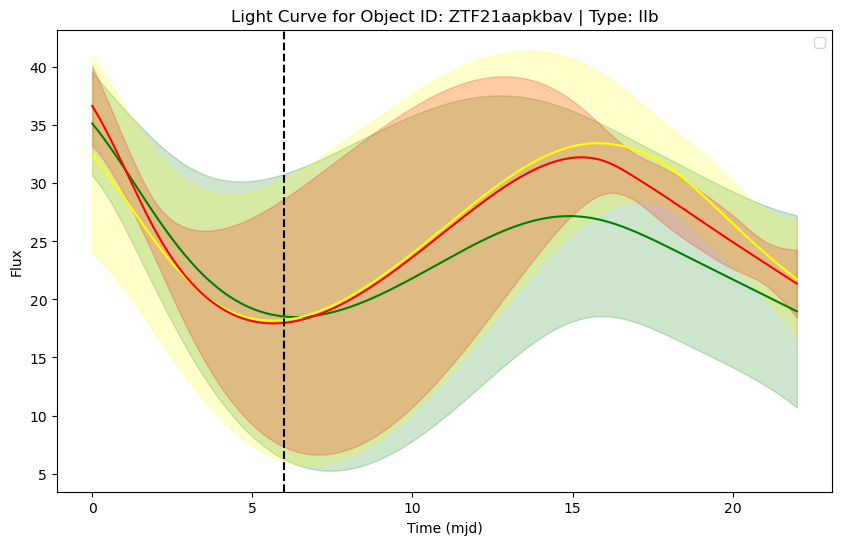

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


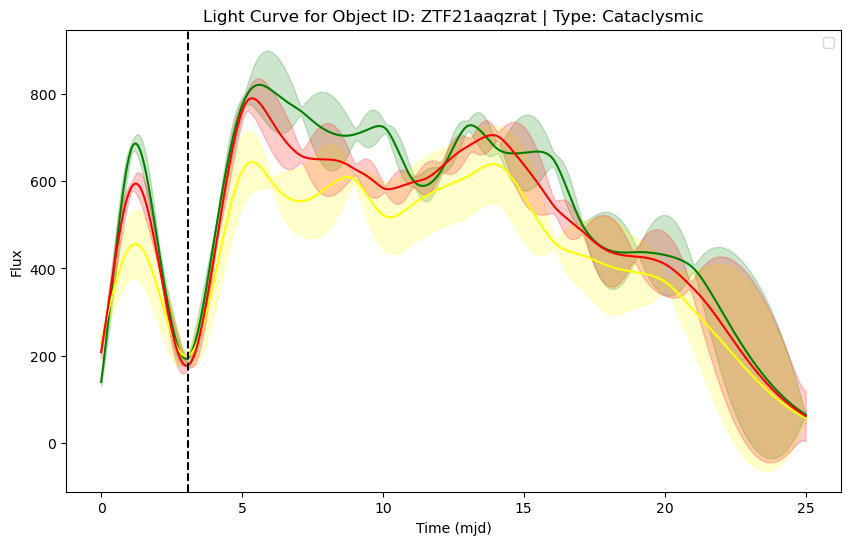

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


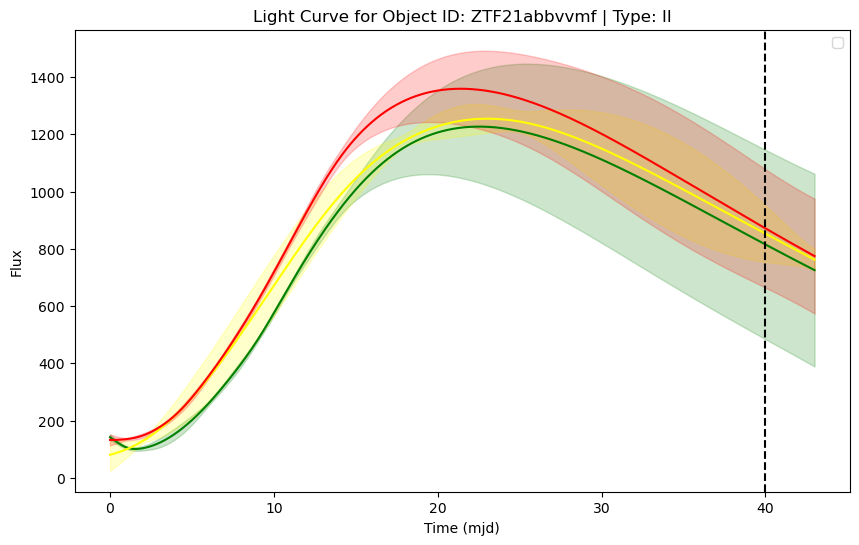

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


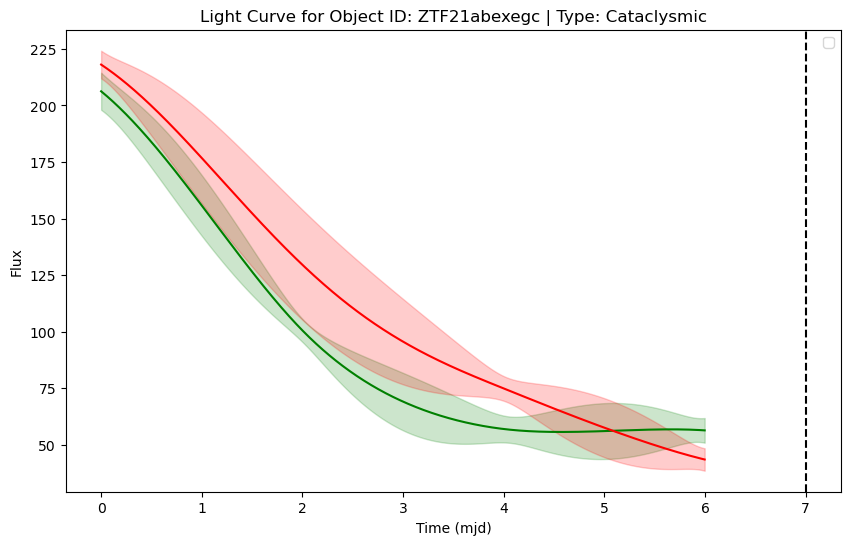

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


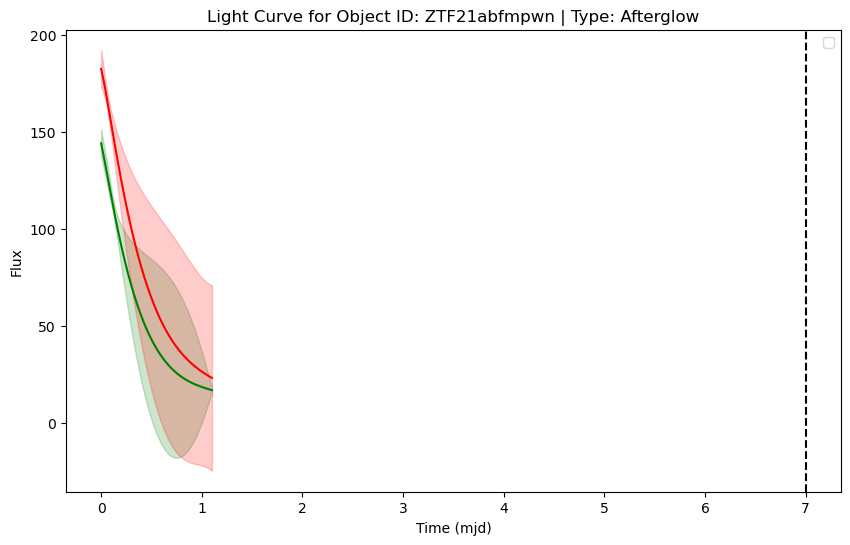

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


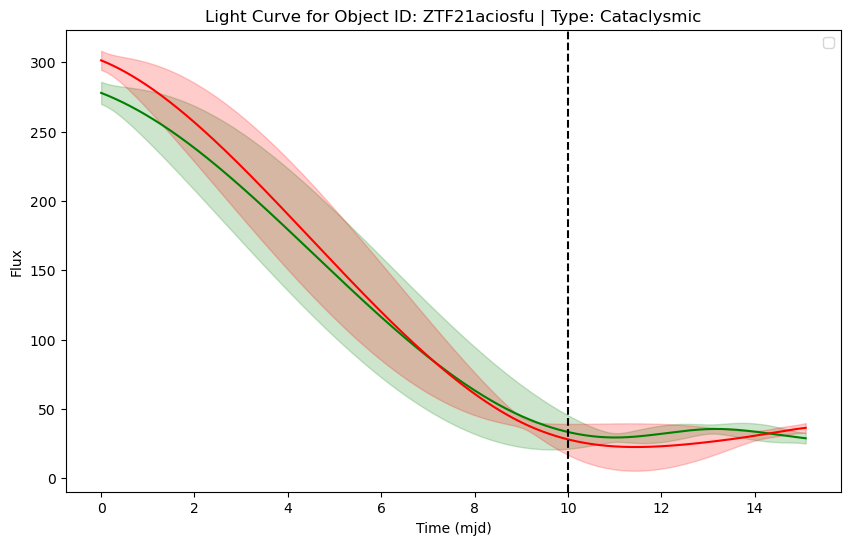

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


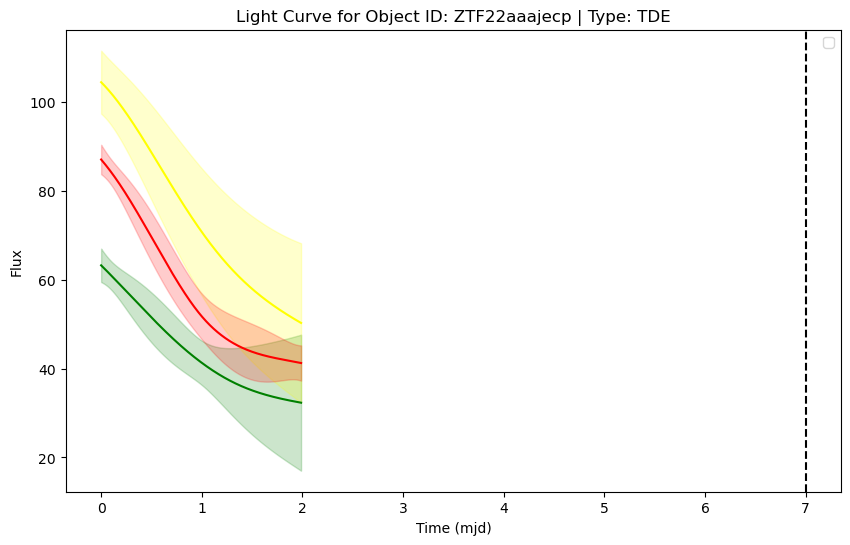

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


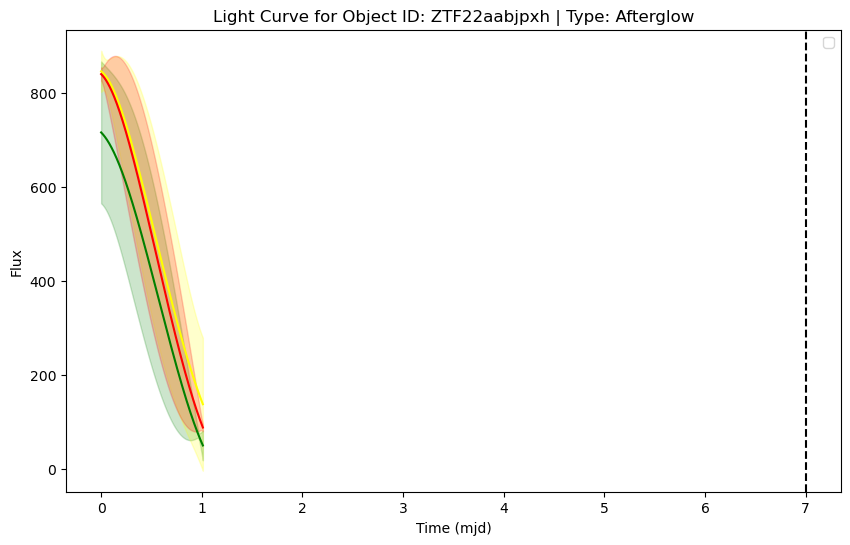

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


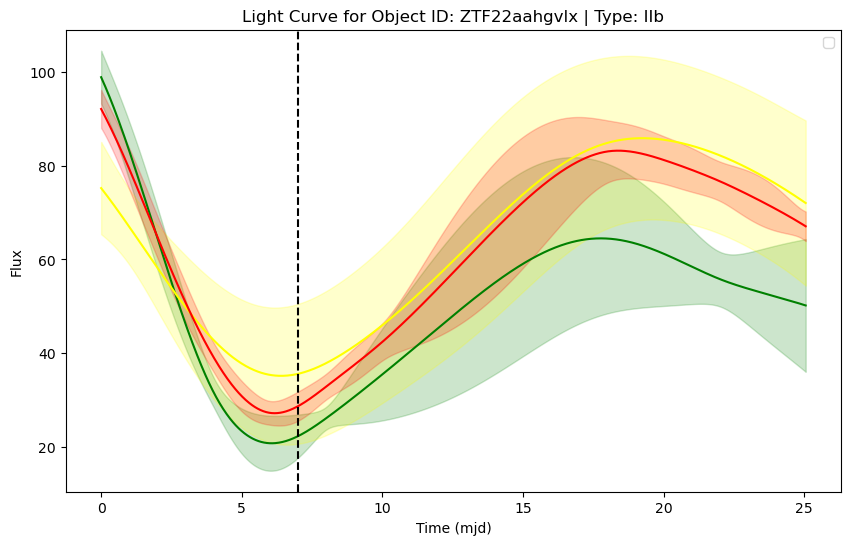

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


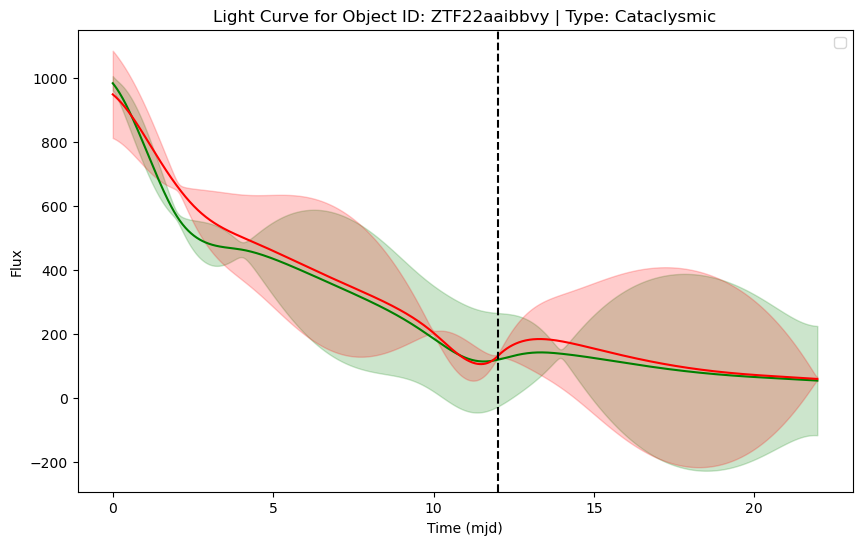

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


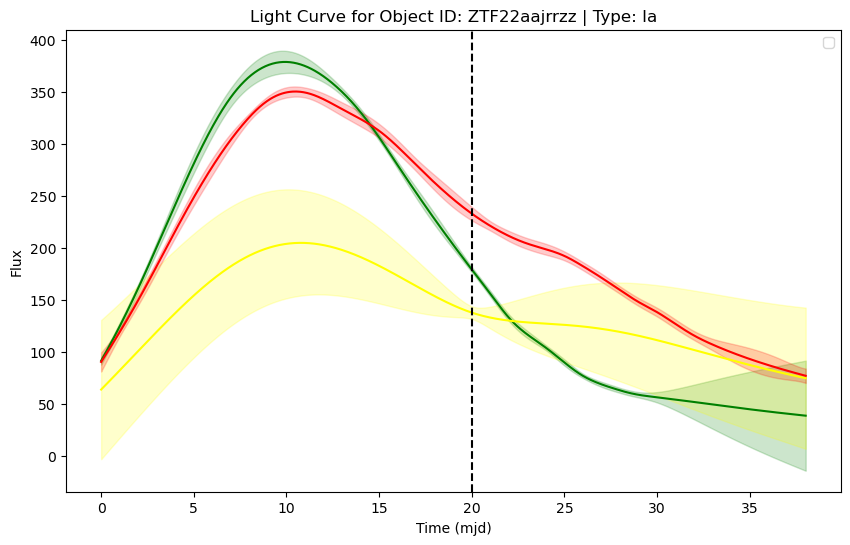

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


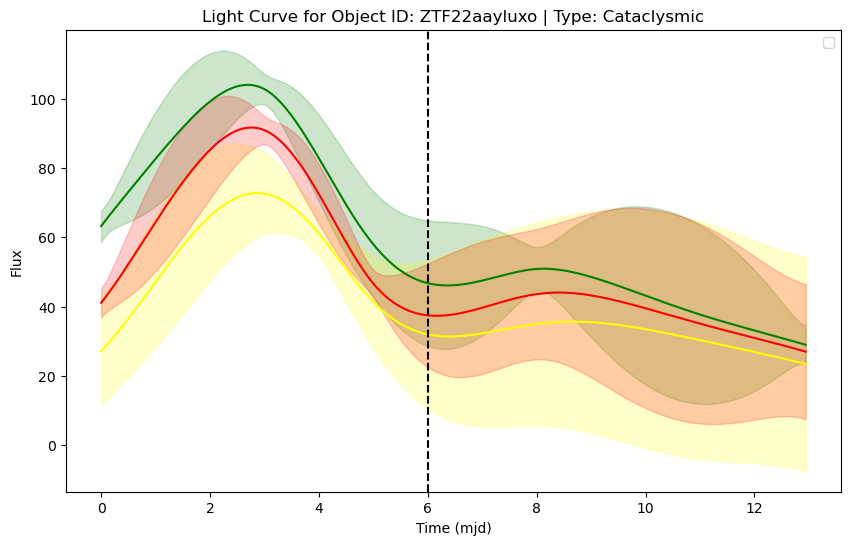

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


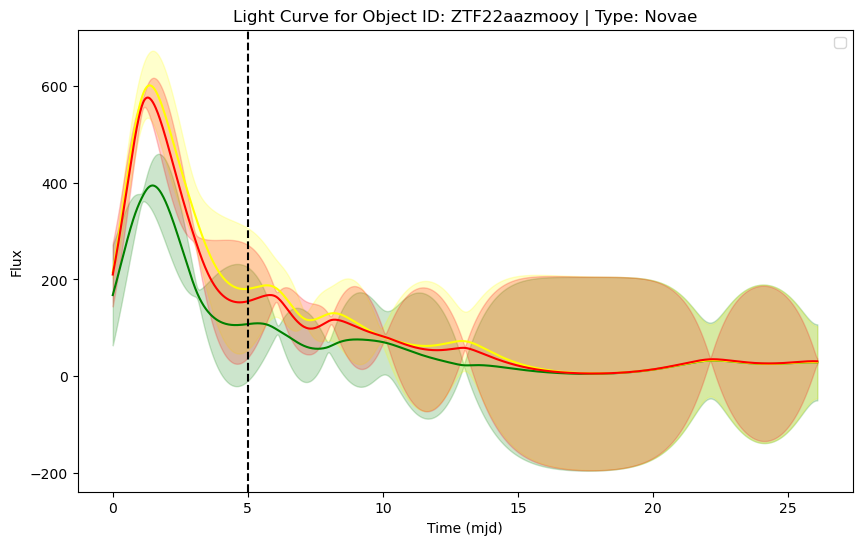

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


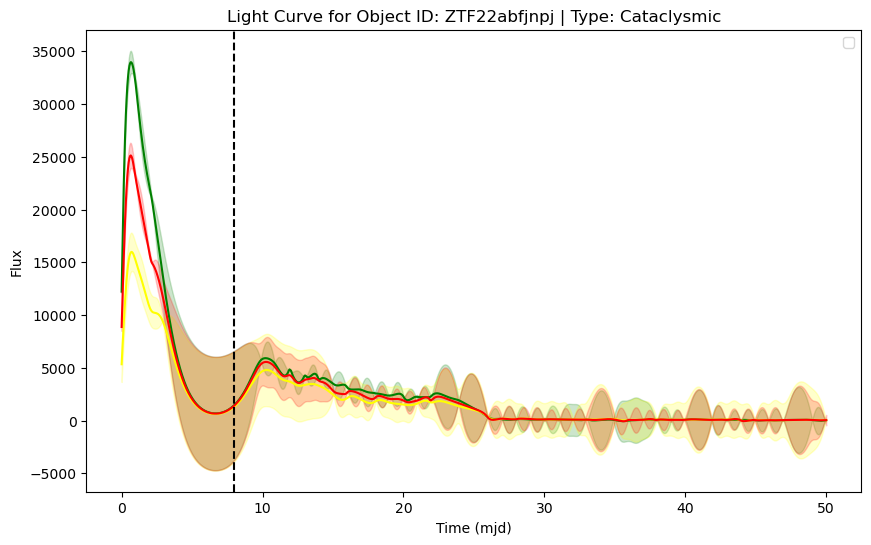

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


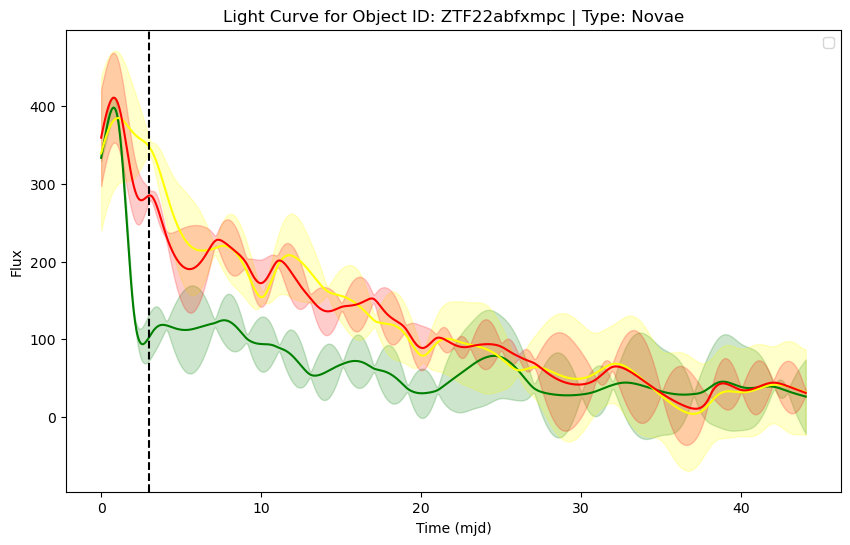

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


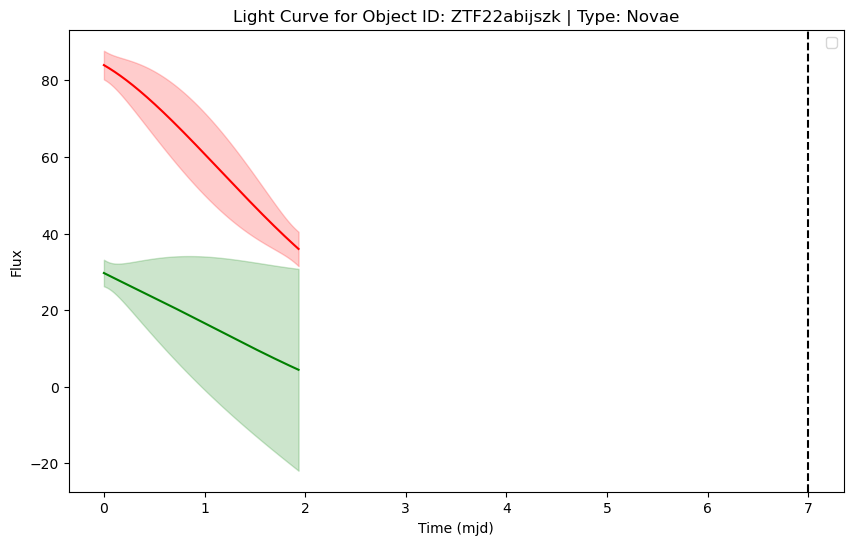

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


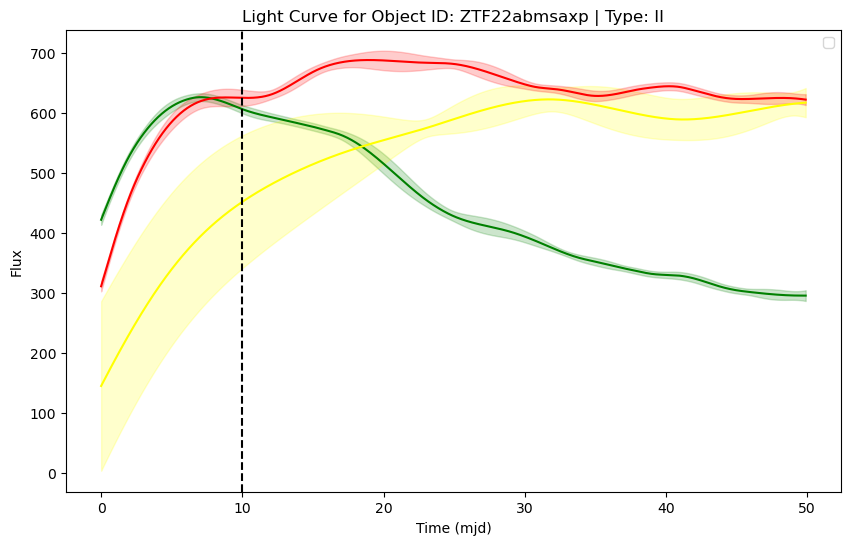

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


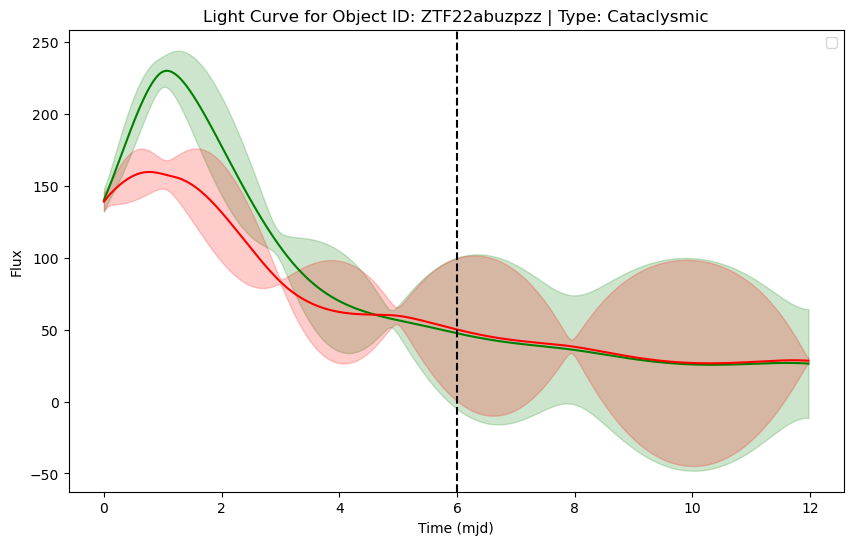

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


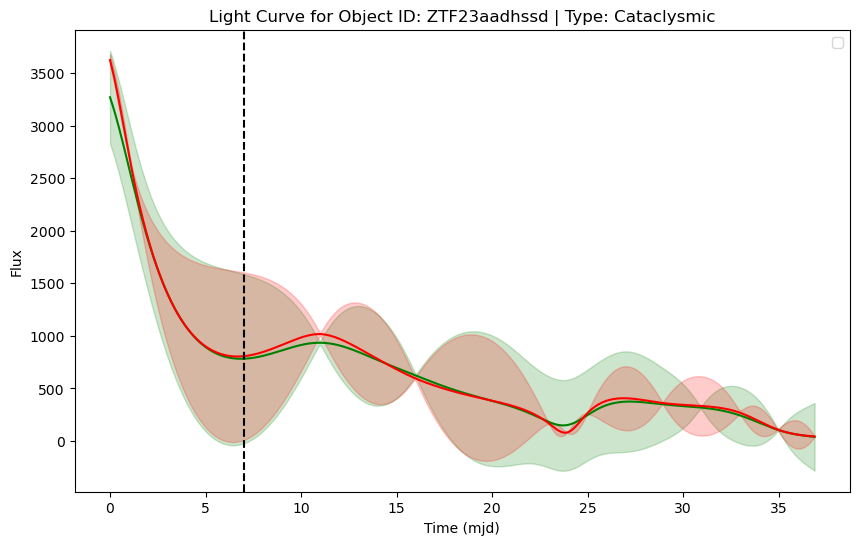

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


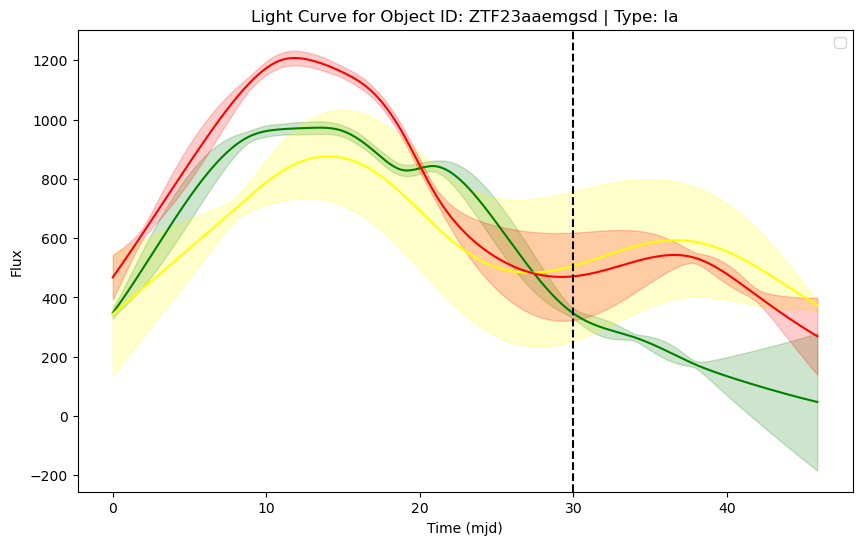

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


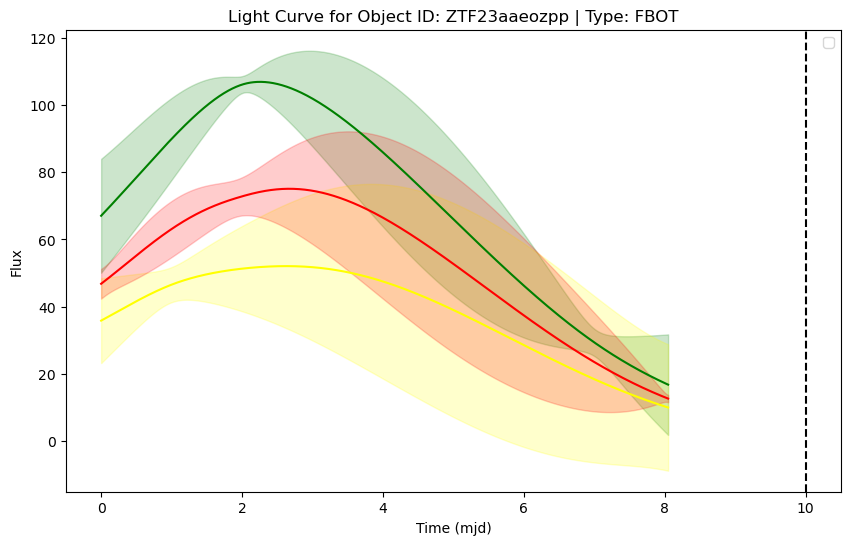

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


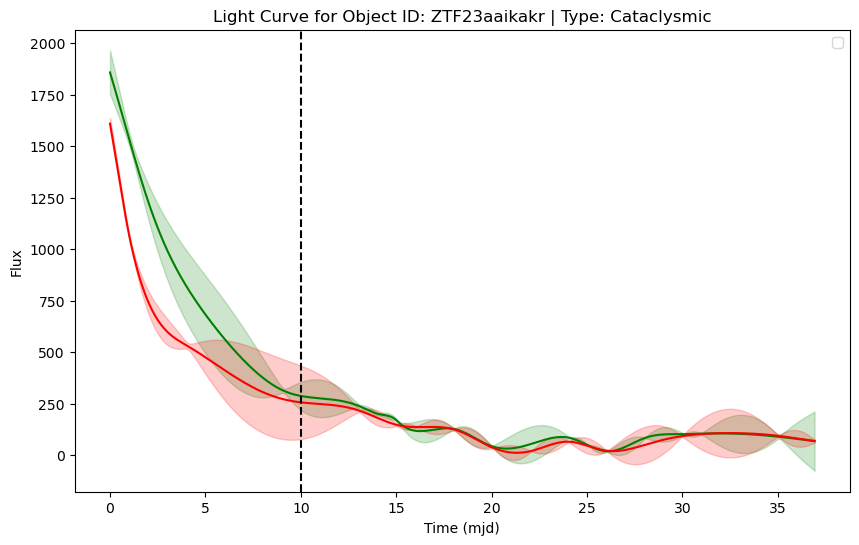

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


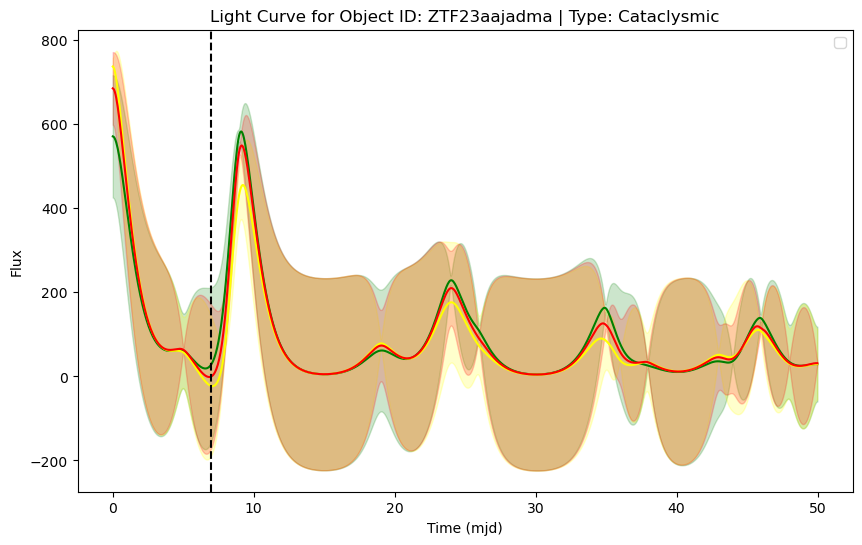

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


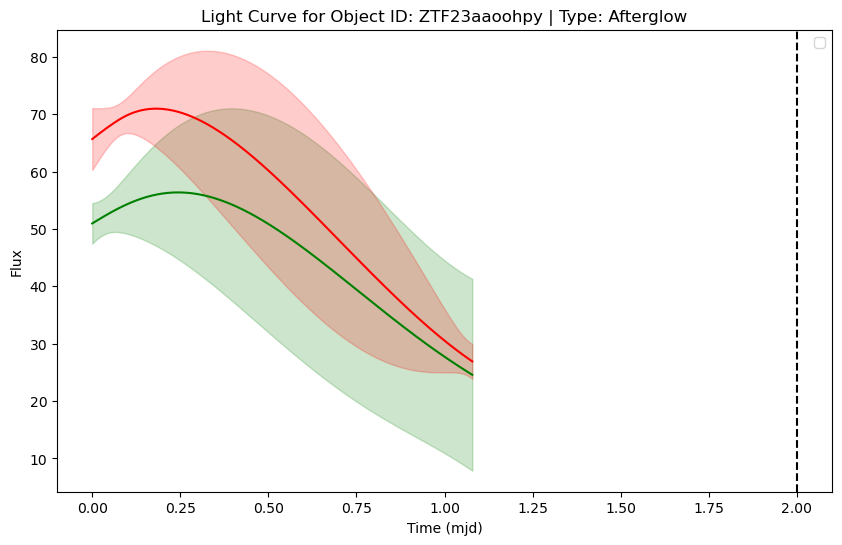

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


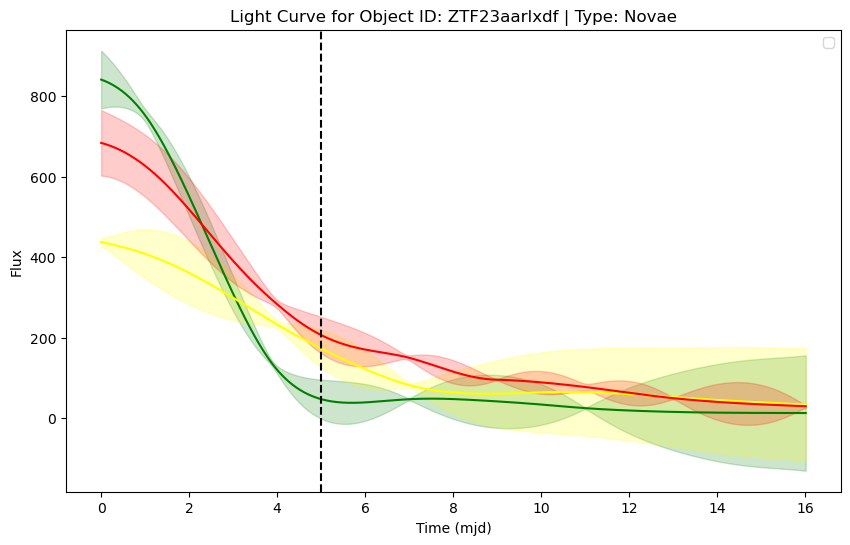

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


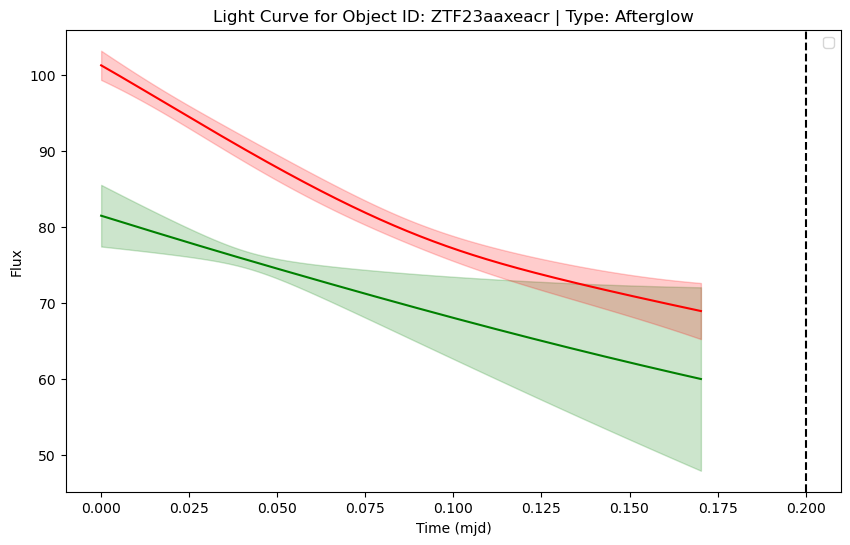

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


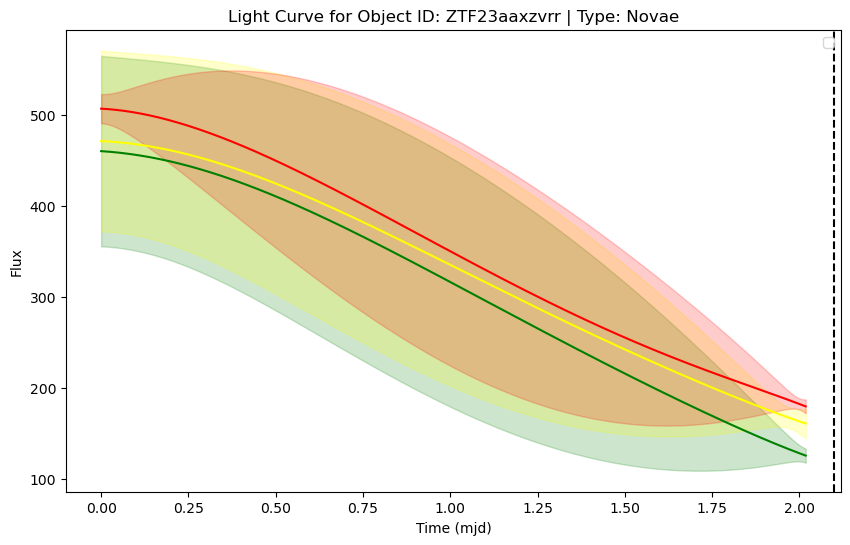

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


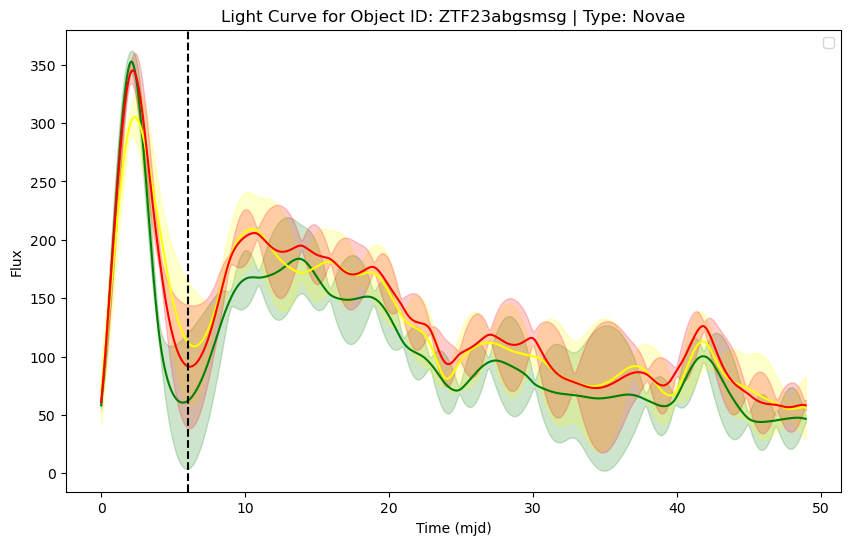

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


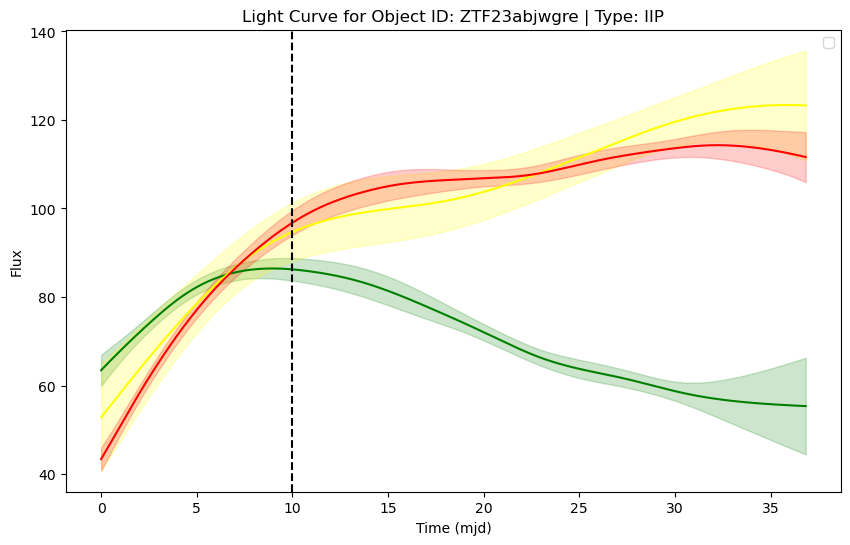

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


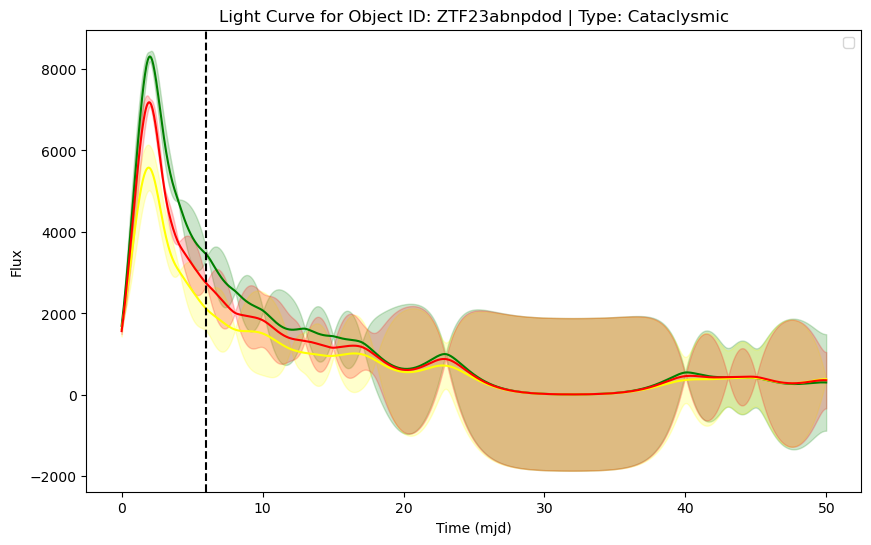

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


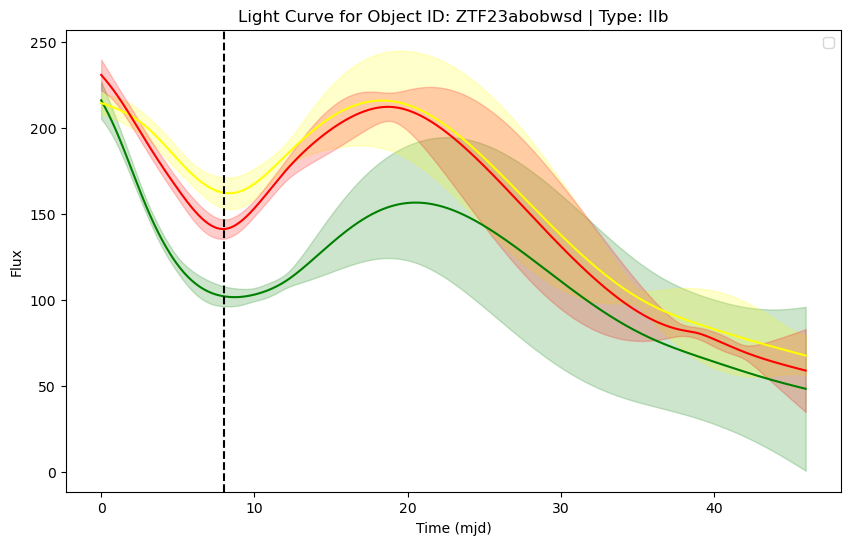

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


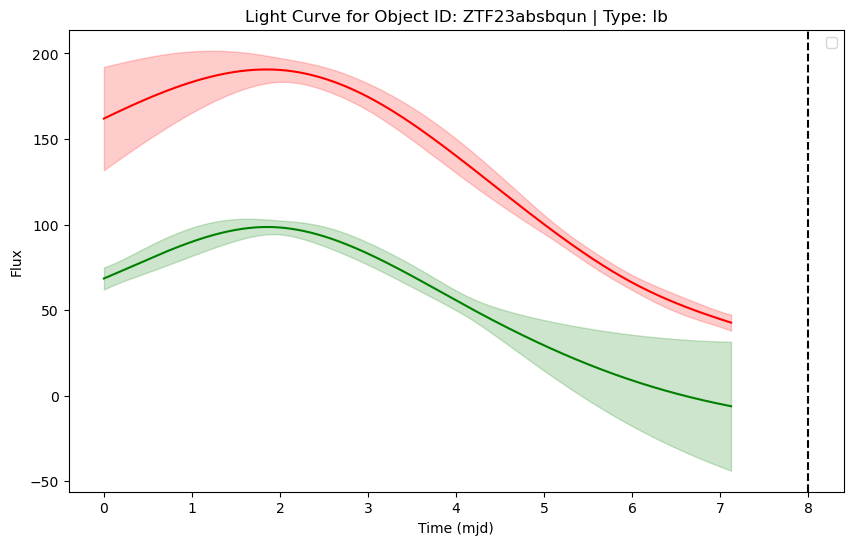

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


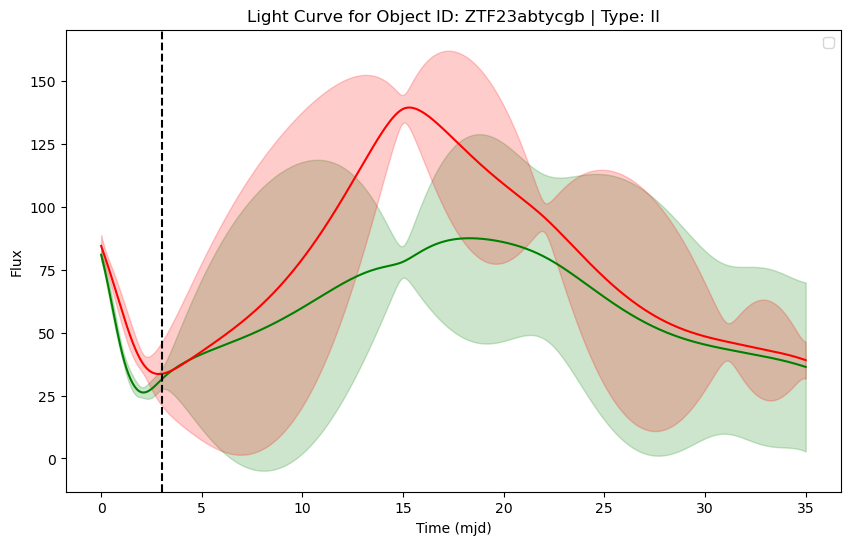

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


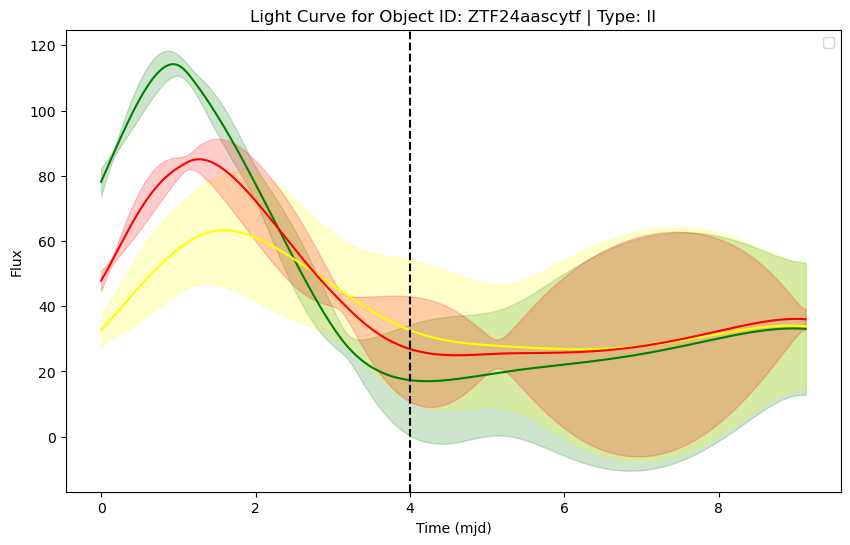

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


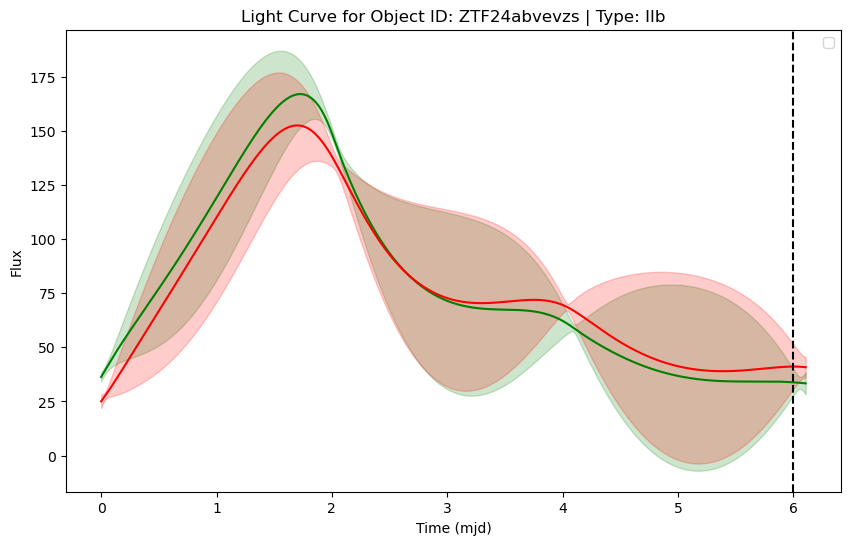

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


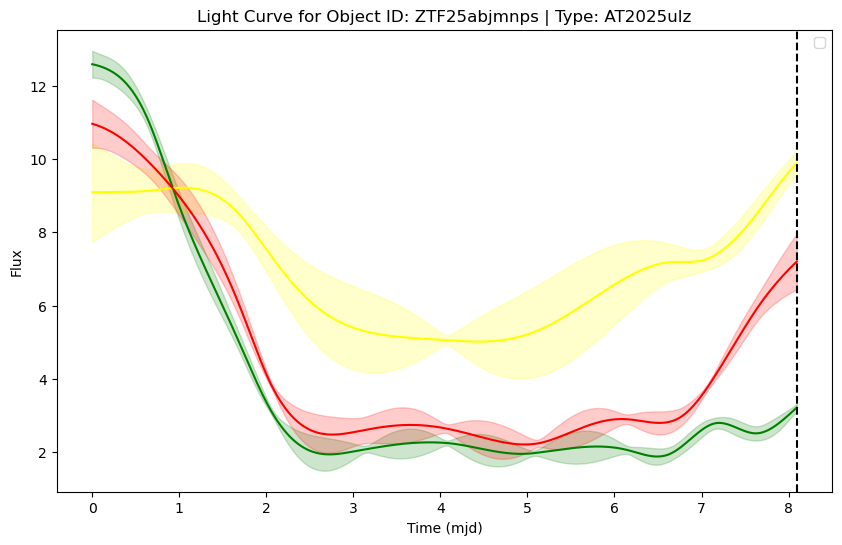

In [7]:
## really should make this less hacky
df = cut_data(df, obj[0], 10)
df = cut_data(df, obj[1], 15)
df = cut_data(df, obj[2], 7)
df = cut_data(df, obj[3], 10)
df = cut_data(df, obj[4], 12)
df = cut_data(df, obj[5], 12)
df = cut_data(df, obj[6], 23)
df = cut_data(df, obj[7], 15)
df = cut_data(df, obj[8], 12)
df = cut_data(df, obj[9], 6)
df = cut_data(df, obj[10], 3)
df = cut_data(df, obj[11], 25)
df = cut_data(df, obj[12], 11)
df = cut_data(df, obj[13], 10)
df = cut_data(df, obj[14], 20)
df = cut_data(df, obj[15], 6)
df = cut_data(df, obj[16], 10)
df = cut_data(df, obj[17], 13)
df = cut_data(df, obj[18], 20)
df = cut_data(df, obj[19], 10)
df = cut_data(df, obj[20], 25)
df = cut_data(df, obj[21], 10)
df = df[df['obj_id'] != obj[22]]  # ztfabwysqy not suited to GP
df = cut_data(df, obj[23], 25)
df = cut_data(df, obj[24], 8)
df = cut_data(df, obj[25], 35)
df = cut_data(df, obj[26], 6)
df = cut_data(df, obj[27], 5)
df = cut_data(df, obj[28], 2)
df = cut_data(df, obj[29], 10)
df = cut_data(df, obj[30], 30)
df = cut_data(df, obj[31], 8)
df = cut_data(df, obj[32], 6)
df = cut_data(df, obj[33], 4)
df = cut_data(df, obj[34], 3)
df = cut_data(df, obj[35], 6)
df = cut_data(df, obj[36], 3.1)
df = cut_data(df, obj[37], 40)
df = cut_data(df, obj[38], 7)
df = cut_data(df, obj[39], 7)
df = df[df['obj_id'] != obj[40]]  # ZTF21abhywxv not suited to GP
# df = cut_data(df, obj[40], 3)
df = cut_data(df, obj[41], 10)
df = cut_data(df, obj[42], 7)
df = cut_data(df, obj[43], 7)
df = cut_data(df, obj[44], 7)
df = cut_data(df, obj[45], 12)
df = cut_data(df, obj[46], 20)
df = cut_data(df, obj[47], 6)
df = cut_data(df, obj[48], 5)
df = cut_data(df, obj[49], 8)
df = cut_data(df, obj[50], 3)
df = cut_data(df, obj[51], 7)
df = cut_data(df, obj[52], 10)
#df = cut_data(df,obj[52], 7) ## ZTF22abntkbk was bogus, so the index shifted
df = cut_data(df,obj[53], 6)
df = df[df['obj_id'] != obj[54]]
df = cut_data(df,obj[55], 7)
df = cut_data(df,obj[56], 30)
df = cut_data(df,obj[57], 10)
df = cut_data(df,obj[58], 10)
df = df[df['obj_id'] != obj[59]]
df = cut_data(df,obj[60], 7)
df = cut_data(df,obj[61], 2)
df = cut_data(df,obj[62], 5)
df = cut_data(df,obj[63], 0.2)
df = cut_data(df,obj[64], 2.1)
df = cut_data(df,obj[65], 6)
df = cut_data(df,obj[66], 10)
df = cut_data(df,obj[67], 6)
df = cut_data(df,obj[68], 8)
df = df[df['obj_id'] != obj[69]]
df = cut_data(df,obj[70], 8)
df = cut_data(df,obj[71], 3)
df = cut_data(df,obj[72], 4)
df = cut_data(df,obj[73], 6)
df = cut_data(df,obj[74], 8.1)
# df = cut_data(df,obj[75], 1.5)

In [8]:
df[df['obj_id'] == obj[-1]]

mjd  flux_ztfg  flux_ztfi  flux_ztfr  flux_error_ztfg  \
73001  60905.188368  12.590232   9.093358  10.963429         0.368367   
73002  60905.196471  12.586238   9.093839  10.957884         0.363200   
73003  60905.204574  12.582020   9.094291  10.952144         0.358508   
73004  60905.212677  12.577579   9.094717  10.946208         0.354281   
73005  60905.220780  12.572916   9.095117  10.940075         0.350502   
...             ...        ...        ...        ...              ...   
73996  60913.250852   3.143694   9.806161   7.127932         0.115217   
73997  60913.258955   3.161257   9.826886   7.146532         0.115187   
73998  60913.267058   3.178820   9.847333   7.164981         0.116439   
73999  60913.275161   3.196376   9.867496   7.183280         0.119048   
74000  60913.283264   3.213920   9.887368   7.201429         0.122988   

       flux_error_ztfi  flux_error_ztfr       type        obj_id  \
73001         1.340095         0.659792  AT2025ulz  ZTF25abjmnps   
73002         1.327958         0.652419  AT2025ulz  ZTF25abjmnps   
73003         1.315843         0.645280  AT2025ulz  ZTF25abjmnps   
73004         1.303750         0.638381  AT2025ulz  ZTF25abjmnps   
73005         1.291679         0.631726  AT2025ulz  ZTF25abjmnps   
...                ...              ...        ...           ...   
73996         0.340238         0.728066  AT2025ulz  ZTF25abjmnps   
73997         0.342336         0.736882  AT2025ulz  ZTF25abjmnps   
73998         0.344971         0.745716  AT2025ulz  ZTF25abjmnps   
73999         0.348165         0.754567  AT2025ulz  ZTF25abjmnps   
74000         0.351939         0.763435  AT2025ulz  ZTF25abjmnps   

              mjd_0  ...   mag_ztfg  abs_mag_ztfg  mag_error_ztfg   mag_ztfr  \
73001  60905.188368  ...  21.149916    -16.857187        0.031767  21.300134   
73002  60905.188368  ...  21.150260    -16.856842        0.031331  21.300683   
73003  60905.188368  ...  21.150624    -16.856479        0.030937  21.301252   
73004  60905.188368  ...  21.151007    -16.856095        0.030583  21.301841   
73005  60905.188368  ...  21.151410    -16.855693        0.030268  21.302449   
...             ...  ...        ...           ...             ...        ...   
73996  60905.188368  ...  22.656399    -15.350703        0.039792  21.767591   
73997  60905.188368  ...  22.650351    -15.356752        0.039561  21.764762   
73998  60905.188368  ...  22.644335    -15.362768        0.039770  21.761962   
73999  60905.188368  ...  22.638355    -15.368747        0.040438  21.759193   
74000  60905.188368  ...  22.632412    -15.374690        0.041548  21.756453   

       abs_mag_ztfr  mag_error_ztfr   mag_ztfi  abs_mag_ztfi  mag_error_ztfi  \
73001    -16.706969        0.065341  21.503189    -16.503913        0.160006   
73002    -16.706419        0.064643  21.503132    -16.503971        0.158548   
73003    -16.705850        0.063970  21.503078    -16.504025        0.157094   
73004    -16.705262        0.063320  21.503027    -16.504076        0.155643   
73005    -16.704653        0.062695  21.502979    -16.504123        0.154195   
...             ...             ...        ...           ...             ...   
73996    -16.239511        0.110900  21.421252    -16.585850        0.037671   
73997    -16.242341        0.111951  21.418960    -16.588142        0.037823   
73998    -16.245140        0.113001  21.416703    -16.590399        0.038035   
73999    -16.247910        0.114051  21.414483    -16.592620        0.038309   
74000    -16.250649        0.115101  21.412298    -16.594804        0.038647   

              t  
73001  0.000000  
73002  0.008103  
73003  0.016206  
73004  0.024309  
73005  0.032412  
...         ...  
73996  8.062484  
73997  8.070587  
73998  8.078690  
73999  8.086793  
74000  8.094896  

[1000 rows x 21 columns]

In [9]:
# df = pd.read_csv('gp_objects_gp1000.csv')
rise_fade = pd.read_csv('gp_rise_fade_stats.csv')
rise_fade

Object  rise fade                                 notes
0   ZTF18aakuewf    y    y                                   NaN
1   ZTF18aalrxas    y    y                                   NaN
2   ZTF18abffyqp    y    y                                   NaN
3   ZTF18abvkmgw    y    y                                   NaN
4   ZTF18abwkrbl    y    y                                   NaN
..           ...  ...  ...                                   ...
67  ZTF23abtycgb    n    y                                   NaN
68  ZTF24aascytf    y    y                                   NaN
69  ZTF24abvevzs    y    y                                   NaN
70     AT2017gfo    n    y                                   NaN
71  ZTF25abjmnps    n    y  cut at 2.1 with Wendelstein 3KK data

[72 rows x 4 columns]

In [10]:
rise_fade.columns

Index(['Object ', 'rise', 'fade', 'notes'], dtype='object')

In [11]:
# for i in rise_fade['Object ']:
#     df.loc(df['obj_id'] == i)['rise'] = rise_fade[rise_fade['Object '] == i]['rise'].values[0]
#     df.loc(df['obj_id'] == i)['fade'] = rise_fade[rise_fade['Object '] == i]['fade'].values[0]
df_array = []
for object in sorted(rise_fade['Object '].unique()):
    # print(object)
    sub_df = df[df['obj_id'] == object]
    rise = rise_fade[rise_fade['Object '] == object]['rise'].values[0]
    fade = rise_fade[rise_fade['Object '] == object]['fade'].values[0]
    df_array.append(sub_df.assign(rise=rise, fade=fade))
df = pd.concat(df_array)

In [12]:
df[df['obj_id'] == obj[-10]]

mjd  flux_ztfg   flux_ztfi  flux_ztfr  flux_error_ztfg  \
64001  60212.383866  58.312737   70.177666  61.156113         3.678733   
64002  60212.432836  64.923492   75.695714  67.622635         3.578260   
64003  60212.481806  71.825578   81.365392  74.340565         4.853082   
64004  60212.530777  79.001282   87.180488  81.296656         6.654043   
64005  60212.579747  86.431995   93.133845  88.476891         8.569468   
...             ...        ...         ...        ...              ...   
64119  60218.162359  60.715410  116.973154  93.845084        56.163695   
64120  60218.211329  60.880572  115.832875  93.236849        56.652104   
64121  60218.260299  61.107795  114.780960  92.715859        57.091217   
64122  60218.309269  61.395770  113.816673  92.280632        57.481502   
64123  60218.358240  61.743255  112.939252  91.929743        57.823458   

       flux_error_ztfi  flux_error_ztfr   type        obj_id         mjd_0  \
64001        28.284792         3.095638  Novae  ZTF23abgsmsg  60212.383866   
64002        28.042059         3.889728  Novae  ZTF23abgsmsg  60212.383866   
64003        27.908862         5.581938  Novae  ZTF23abgsmsg  60212.383866   
64004        27.875753         7.485641  Novae  ZTF23abgsmsg  60212.383866   
64005        27.930546         9.389908  Novae  ZTF23abgsmsg  60212.383866   
...                ...              ...    ...           ...           ...   
64119        52.415871        51.470920  Novae  ZTF23abgsmsg  60212.383866   
64120        52.487698        51.822287  Novae  ZTF23abgsmsg  60212.383866   
64121        52.501446        52.113703  Novae  ZTF23abgsmsg  60212.383866   
64122        52.456536        52.345594  Novae  ZTF23abgsmsg  60212.383866   
64123        52.352452        52.518428  Novae  ZTF23abgsmsg  60212.383866   

       ...  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  mag_error_ztfr  \
64001  ...        0.068495  19.433900      4.870665        0.054958   
64002  ...        0.059840  19.324770      4.761534        0.062453   
64003  ...        0.073361  19.221935      4.658700        0.081524   
64004  ...        0.091448  19.124818      4.561583        0.099973   
64005  ...        0.107647  19.032925      4.469690        0.115227   
...    ...             ...        ...           ...             ...   
64119  ...        1.004341  18.968971      4.405736        0.595490   
64120  ...        1.010326  18.976031      4.412795        0.603467   
64121  ...        1.014371  18.982115      4.418879        0.610270   
64122  ...        1.016515  18.987224      4.423988        0.615877   
64123  ...        1.016808  18.991360      4.428124        0.620269   

        mag_ztfi  abs_mag_ztfi  mag_error_ztfi         t  rise  fade  
64001  19.284503      4.721267        0.437601  0.000000     y     y  
64002  19.202322      4.639086        0.402219  0.048970     y     y  
64003  19.123901      4.560665        0.372415  0.097941     y     y  
64004  19.048952      4.485716        0.347162  0.146911     y     y  
64005  18.977231      4.413996        0.325609  0.195881     y     y  
...          ...           ...             ...       ...   ...   ...  
64119  18.729784      4.166549        0.486520  5.778493     y     y  
64120  18.740420      4.177185        0.491983  5.827463     y     y  
64121  18.750325      4.187090        0.496622  5.876433     y     y  
64122  18.759485      4.196250        0.500401  5.925404     y     y  
64123  18.767888      4.204652        0.503288  5.974374     y     y  

[123 rows x 23 columns]

In [13]:
df.type.unique()

array(['Kilonova', 'Ibn', 'IIb', 'II', 'Ib', 'Afterglow', 'Ia', 'Novae',
       'Cataclysmic', 'TDE', 'FBOT', 'IIP', 'AT2025ulz'], dtype=object)

In [14]:
df.obj_id.unique()

array(['AT2017gfo', 'ZTF18aakuewf', 'ZTF18aalrxas', 'ZTF18abffyqp',
       'ZTF18abvkmgw', 'ZTF18abwkrbl', 'ZTF19aanbpus', 'ZTF19aapfmki',
       'ZTF19aatesgp', 'ZTF19abacxod', 'ZTF19abxjrge', 'ZTF19abxtcio',
       'ZTF19abyjzvd', 'ZTF19acbumks', 'ZTF19accjfgv', 'ZTF20aahfqpm',
       'ZTF20aajnksq', 'ZTF20aaxhzhc', 'ZTF20aayrobw', 'ZTF20aazchcq',
       'ZTF20abstsxb', 'ZTF20aburywx', 'ZTF20abwzqzo', 'ZTF20acgigfo',
       'ZTF20acgiglu', 'ZTF20acigusw', 'ZTF20aclfmwn', 'ZTF20acozryr',
       'ZTF20acqntkr', 'ZTF20actqnhg', 'ZTF21aaabrpu', 'ZTF21aaabwfu',
       'ZTF21aabxjqr', 'ZTF21aagwbjr', 'ZTF21aapkbav', 'ZTF21aaqzrat',
       'ZTF21abbvvmf', 'ZTF21abexegc', 'ZTF21abfmpwn', 'ZTF21aciosfu',
       'ZTF22aaajecp', 'ZTF22aabjpxh', 'ZTF22aahgvlx', 'ZTF22aaibbvy',
       'ZTF22aajrrzz', 'ZTF22aayluxo', 'ZTF22aazmooy', 'ZTF22abfjnpj',
       'ZTF22abfxmpc', 'ZTF22abijszk', 'ZTF22abmsaxp', 'ZTF22abuzpzz',
       'ZTF23aadhssd', 'ZTF23aaemgsd', 'ZTF23aaeozpp', 'ZTF23aaikakr',
       'Z

In [15]:
df.to_csv('gp_objects(downsample).csv', index=False)